# About Dataset

Features:
fraud_bool (boolean) = (1 if fraud, 0 if legit).

income (numeric) = Annual income of the applicant in quantiles. Ranges between [0, 1].

name_email_similarity (numeric) = Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges

prev_address_months_count (numeric) = Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [-1, 380] months (-1 is a missing value).

current_address_months_count (numeric) = Months in currently registered address of the applicant. Ranges between [-1, 429] months (-1 is a missing value).

customer_age (numeric) = Applicant’s age in bins per decade (e.g, 20-29 is represented as 20). Ranges between [10, 90] years.

days_since_request (numeric): Number of days passed since application was done. Ranges between [0, 79] days.

intended_balcon_amount (numeric): Initial transferred amount for application. Ranges between [–16, 114] (negatives are missing values).

payment_type (categorical): Credit payment plan type. 5 possible (anonymized) values.

zip_count_4w (numeric): Number of applications within same zip code in last 4 weeks. Ranges between [1, 6830].

velocity_6h (numeric): Velocity of total applications made in last 6 hours i.e., average number of applications per hour in the last 6 hours. Ranges between [–175, 16818].

velocity_24h (numeric): Velocity of total applications made in last 24 hours i.e., average number of applications per hour in the last 24 hours. Ranges between [1297, 9586].

velocity_4w (numeric): Velocity of total applications made in last 4 weeks i.e., average number of applications per hour in the last 4 weeks. Ranges between [2825, 7020].

bank_branch_count_8w (numeric): Number of total applications in the selected bank branch in last 8 weeks. Ranges between [0, 2404].

date_of_birth_distinct_emails_4w (numeric): Number of emails for applicants with same date of birth in last 4 weeks. Ranges between [0, 39].

employment_status (categorical): Employment status of the applicant. 7 possible (anonymized) values.

credit_risk_score (numeric): Internal score of application risk. Ranges between [–191, 389].

email_is_free (binary): Domain of application email (either free or paid).

housing_status (categorical): Current residential status for applicant. 7 possible (anonymized) values.

phone_home_valid (binary): Validity of provided home phone.

phone_mobile_valid (binary): Validity of provided mobile phone.

bank_months_count (numeric): How old is previous account (if held) in months. Ranges between [–1, 32] months (–1 is a missing value).

has_other_cards (binary): If applicant has other cards from the same banking company.

proposed_credit_limit (numeric): Applicant’s proposed credit limit. Ranges between [200, 2000].

foreign_request (binary): If origin country of request is different from bank’s country.

source (categorical): Online source of application. Either browser (INTERNET) or app (TELEAPP).

session_length_in_minutes (numeric): Length of user session in banking website in minutes. Ranges between [–1, 107] minutes (–1 is a missing value).

device_os (categorical): Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.

keep_alive_session (binary): User option on session logout.

device_distinct_emails (numeric): Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [–1, 2] emails (–1 is a missing value).

device_fraud_count (numeric): Number of fraudulent applications with used device. Ranges between [0, 1].

month (numeric): Month where the application was made. Ranges between [0, 7].

Link dataset: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.callbacks import EarlyStopping
sns.set()

2025-07-15 03:17:04.493771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752549424.670516      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752549424.721171      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Dataset

In [2]:
df = pd.read_csv("/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv")
df

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.8,0.124690,-1,143,30,0.051348,-0.826239,AB,530,...,0,1500.0,0,INTERNET,16.967770,other,0,1,0,7
999996,0,0.9,0.824544,-1,193,30,0.009591,0.008307,AC,408,...,1,1000.0,0,INTERNET,1.504109,macintosh,0,1,0,7
999997,0,0.8,0.140891,-1,202,10,0.059287,50.609995,AA,749,...,0,200.0,0,INTERNET,16.068595,other,0,1,0,7
999998,0,0.9,0.002480,52,3,30,0.023357,-1.313387,AB,707,...,0,200.0,0,INTERNET,1.378683,linux,1,1,0,7


# Data Understanding

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [4]:
df.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,5665.296605,...,0.889676,10.839303,0.222988,515.851010,0.025242,7.544940,0.576947,1.018312,0.0,3.288674
std,0.104438,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,3009.380665,...,0.313293,12.116875,0.416251,487.559902,0.156859,8.033106,0.494044,0.180761,0.0,2.209994
min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,...,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.181488,894.000000,3436.365848,...,1.000000,-1.000000,0.000000,200.000000,0.000000,3.103053,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-0.830507,1263.000000,5319.769349,...,1.000000,5.000000,0.000000,200.000000,0.000000,5.114321,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,1944.000000,7680.717827,...,1.000000,25.000000,0.000000,500.000000,0.000000,8.866131,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16715.565404,...,1.000000,32.000000,1.000000,2100.000000,1.000000,85.899143,1.000000,2.000000,0.0,7.000000


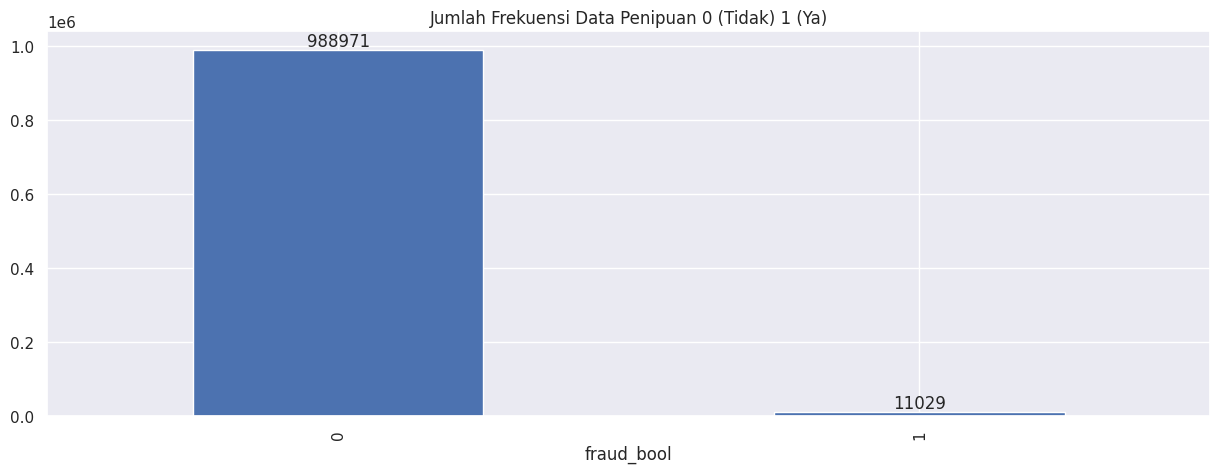

In [5]:
plot = df["fraud_bool"].value_counts()
ax = plot.plot.bar(figsize=(15, 5))
ax.set_title("Jumlah Frekuensi Data Penipuan 0 (Tidak) 1 (Ya)")

for container in ax.containers:
    ax.bar_label(container)

#### Melakukan penghapusan pada pada beberapa data kelas 0 supaya data balance

In [6]:
class_1_count = df[df["fraud_bool"] == 1][["fraud_bool"]].size
df_minority = df[df["fraud_bool"] == 1]
df_majority = df[df["fraud_bool"] == 0]

result = df_majority.iloc[:class_1_count]
df = pd.concat([result, df_minority], axis=0).reset_index(drop=True)
df

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22053,1,0.3,0.346834,-1,13,20,0.007084,-0.994025,AC,692,...,0,200.0,0,INTERNET,23.525141,windows,1,1,0,7
22054,1,0.7,0.161950,289,209,40,0.008195,-0.837462,AC,679,...,0,2000.0,0,INTERNET,9.366778,windows,0,1,0,7
22055,1,0.4,0.098119,-1,139,30,0.028858,-1.383748,AB,345,...,0,500.0,0,INTERNET,2.363665,windows,0,1,0,7
22056,1,0.8,0.830047,-1,73,40,0.009757,-1.439571,AC,623,...,0,1900.0,0,INTERNET,1.596140,linux,0,1,0,7


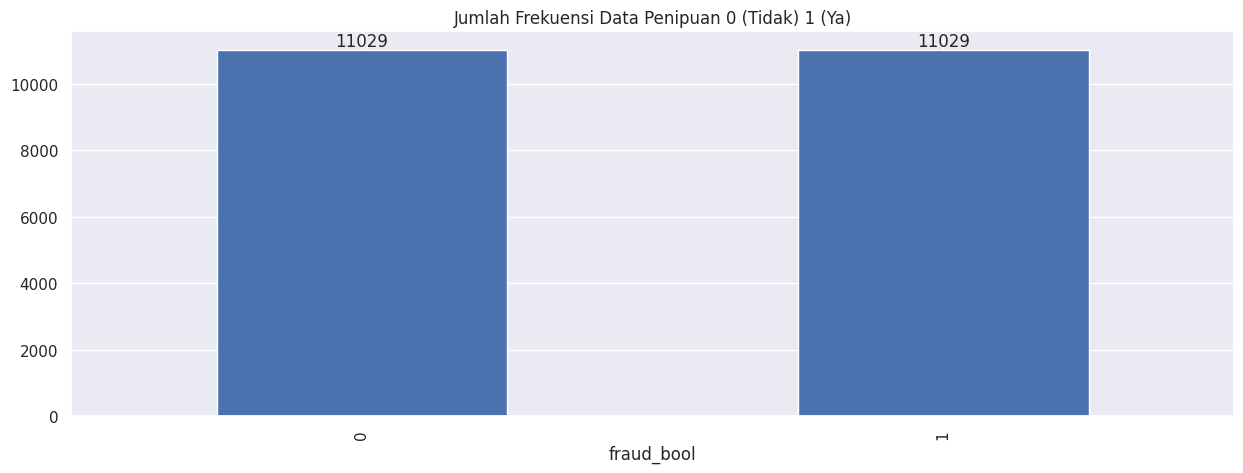

In [7]:
plot = df["fraud_bool"].value_counts()
ax = plot.plot.bar(figsize=(15, 5))
ax.set_title("Jumlah Frekuensi Data Penipuan 0 (Tidak) 1 (Ya)")

for container in ax.containers:
    ax.bar_label(container)

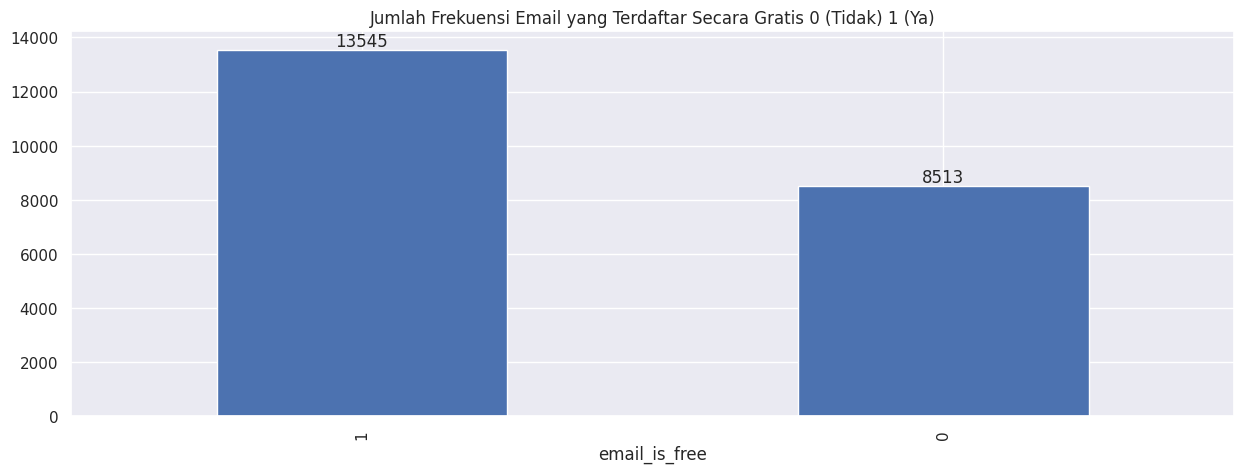

In [8]:
plot = df["email_is_free"].value_counts()
ax = plot.plot.bar(figsize=(15, 5))
ax.set_title("Jumlah Frekuensi Email yang Terdaftar Secara Gratis 0 (Tidak) 1 (Ya)")

for container in ax.containers:
    ax.bar_label(container)

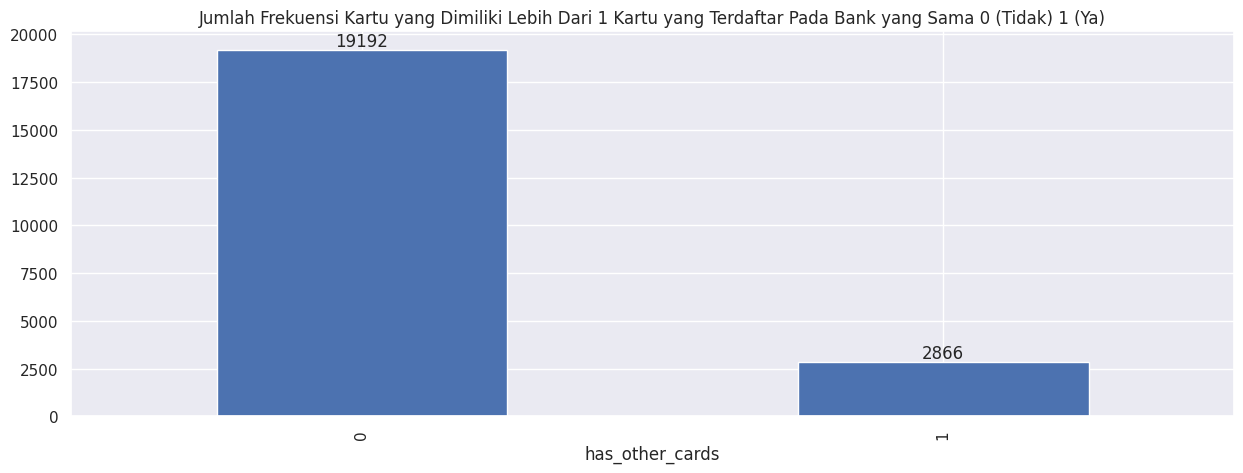

In [9]:
plot = df["has_other_cards"].value_counts()
ax = plot.plot.bar(figsize=(15, 5))
ax.set_title("Jumlah Frekuensi Kartu yang Dimiliki Lebih Dari 1 Kartu yang Terdaftar Pada Bank yang Sama 0 (Tidak) 1 (Ya)")

for container in ax.containers:
    ax.bar_label(container)

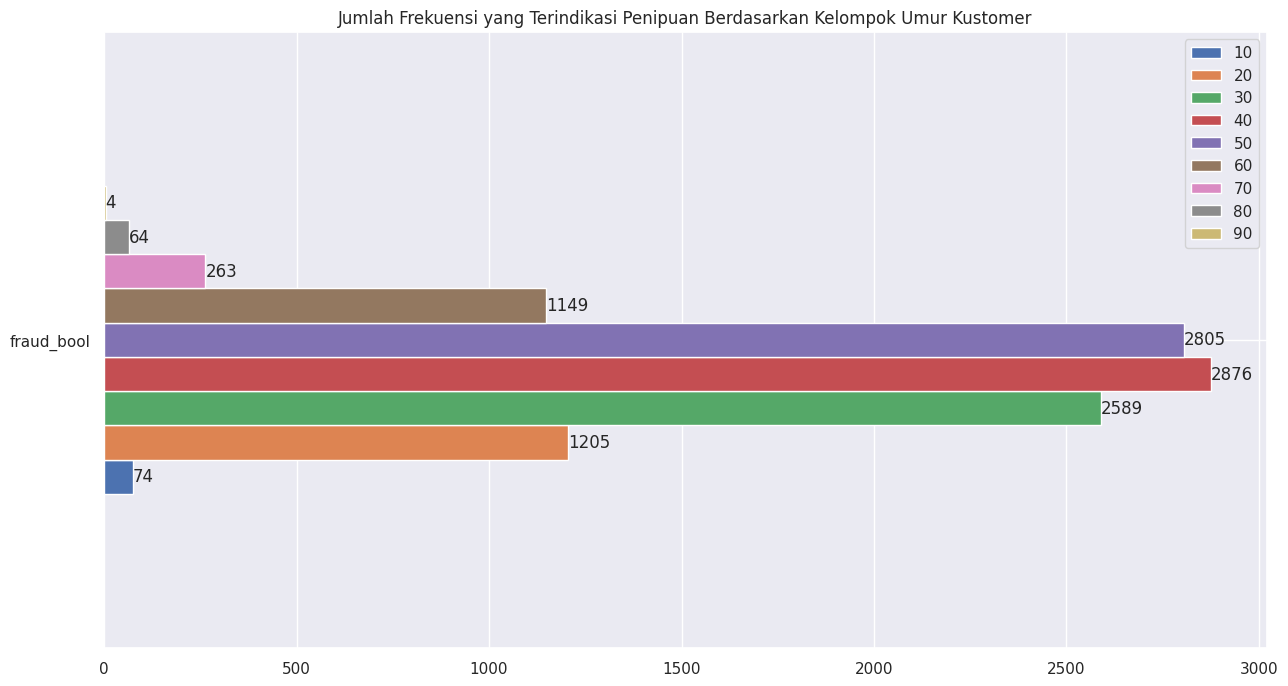

In [10]:
plot = pd.pivot_table(data=df, values="fraud_bool", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Frekuensi yang Terindikasi Penipuan Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


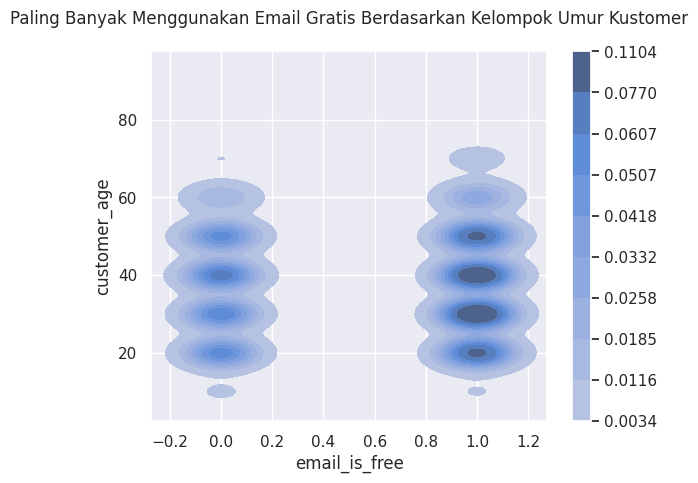

In [11]:
ax = sns.kdeplot(
    data=df,
    x="email_is_free",
    y="customer_age",
    cbar=True,
    fill=True
)
ax.set_title(
    "Paling Banyak Menggunakan Email Gratis Berdasarkan Kelompok Umur Kustomer",
    pad=20  # Atur jarak
)
plt.show()

In [12]:
df

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22053,1,0.3,0.346834,-1,13,20,0.007084,-0.994025,AC,692,...,0,200.0,0,INTERNET,23.525141,windows,1,1,0,7
22054,1,0.7,0.161950,289,209,40,0.008195,-0.837462,AC,679,...,0,2000.0,0,INTERNET,9.366778,windows,0,1,0,7
22055,1,0.4,0.098119,-1,139,30,0.028858,-1.383748,AB,345,...,0,500.0,0,INTERNET,2.363665,windows,0,1,0,7
22056,1,0.8,0.830047,-1,73,40,0.009757,-1.439571,AC,623,...,0,1900.0,0,INTERNET,1.596140,linux,0,1,0,7


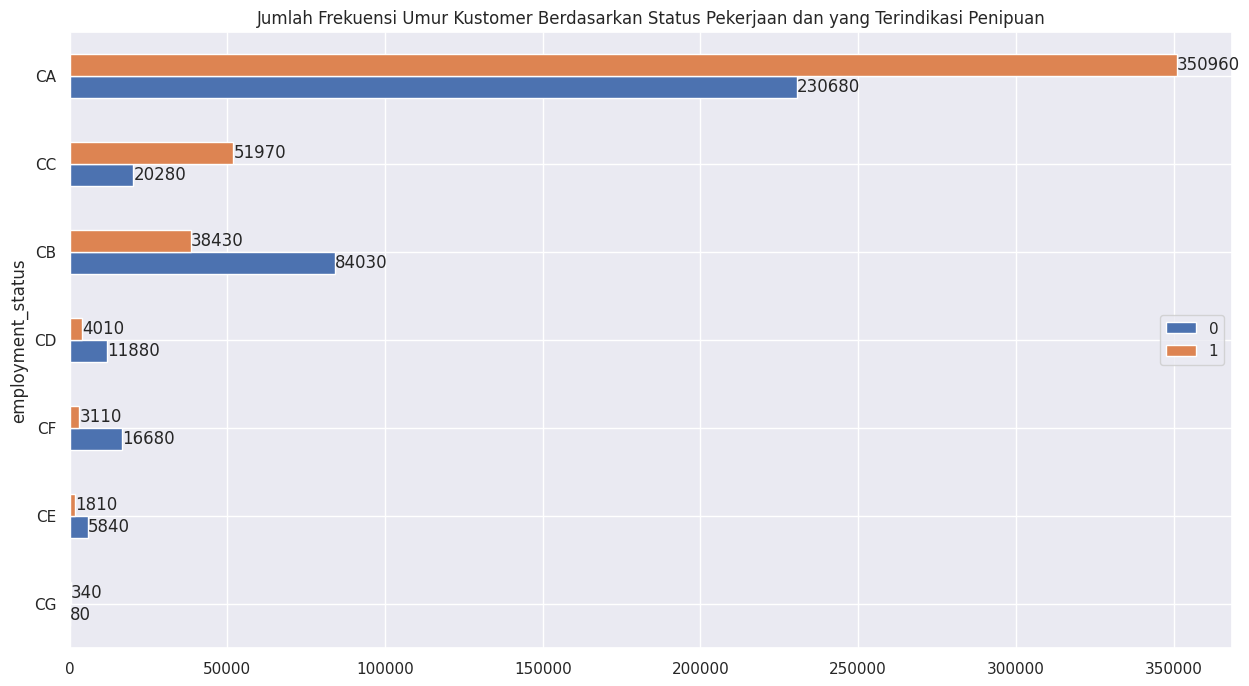

In [13]:
# Mengurutkan berdasarkan fitur fraud_bool 1
plot = df.groupby(["employment_status", "fraud_bool"])["customer_age"].sum().unstack().sort_values(by=1, ascending=True)
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Frekuensi Umur Kustomer Berdasarkan Status Pekerjaan dan yang Terindikasi Penipuan")
ax.legend(loc="center right")

for container in ax.containers:
    ax.bar_label(container)

In [14]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

In [15]:
def print_counts_categorical_features(df):
    for col in categorical_features:
        plt.figure(figsize=(8, 5))
        counts = df[col].value_counts(dropna=False)
        counts.plot(kind='bar')
        plt.title(f'Distribusi Frekuensi Kategori: {col}')
        plt.xlabel(col)
        plt.ylabel('Jumlah')
        plt.xticks(rotation=45, ha='right')
        
        for i, count in enumerate(counts):
            plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=9)
            
        plt.tight_layout()
        plt.show()

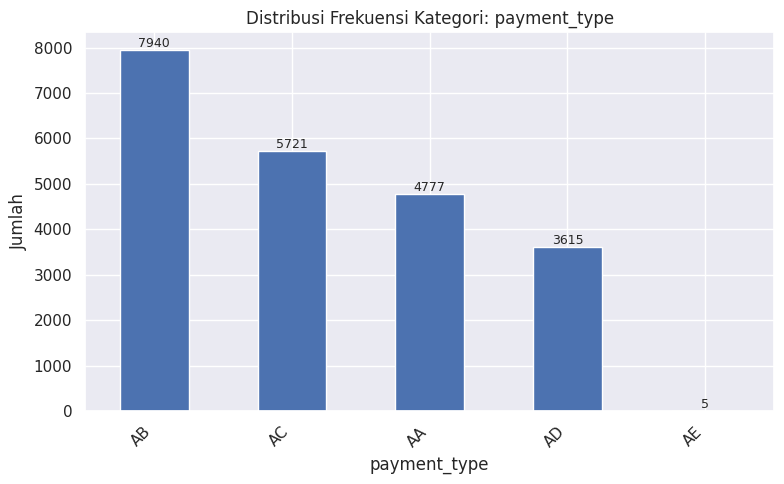

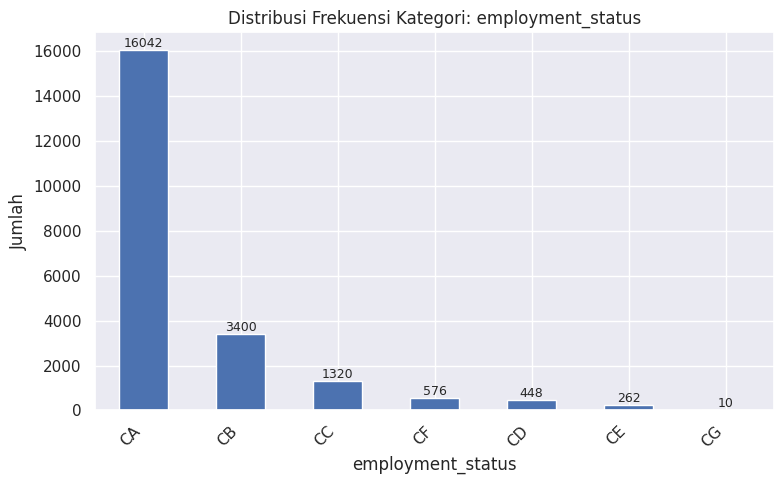

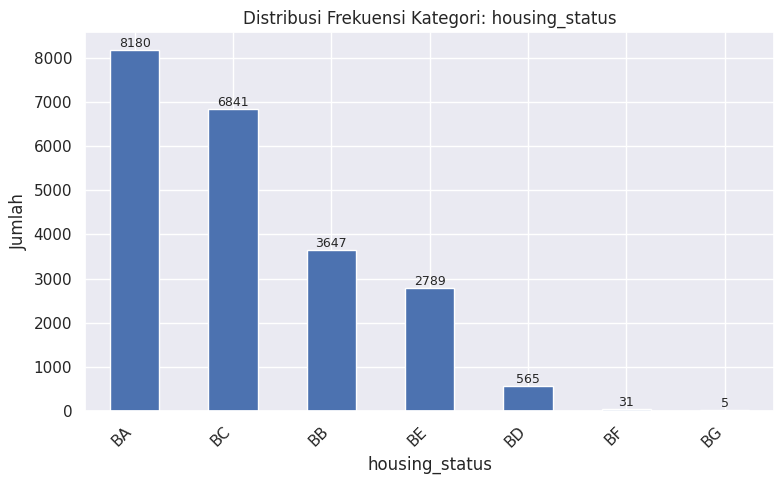

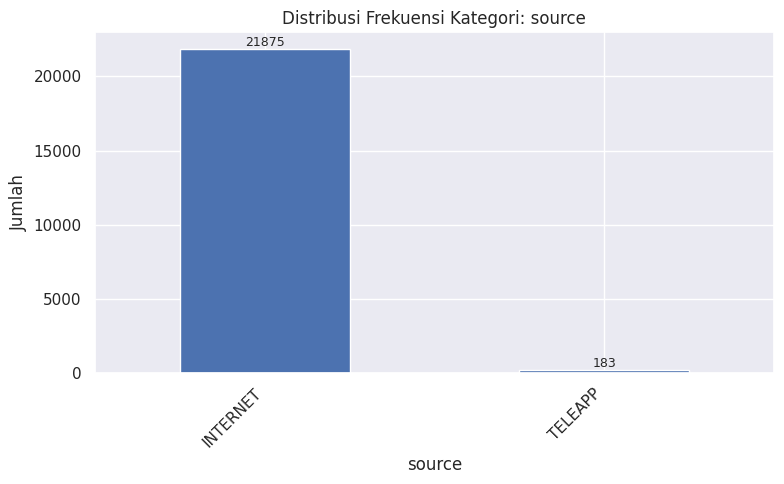

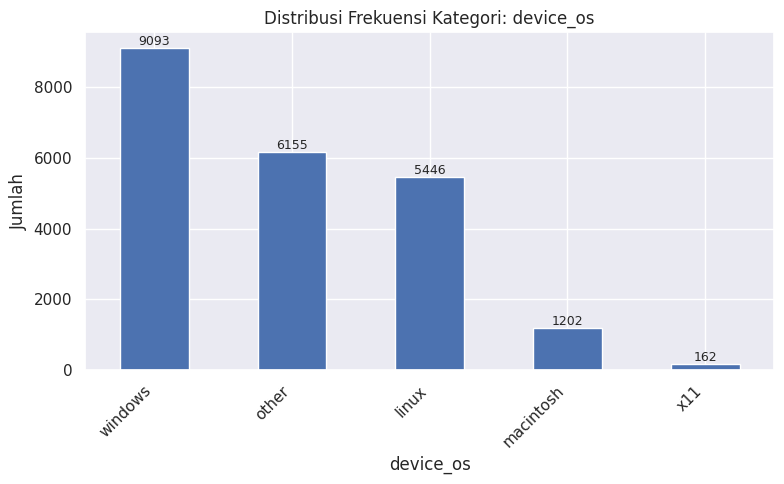

In [16]:
print_counts_categorical_features(df)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

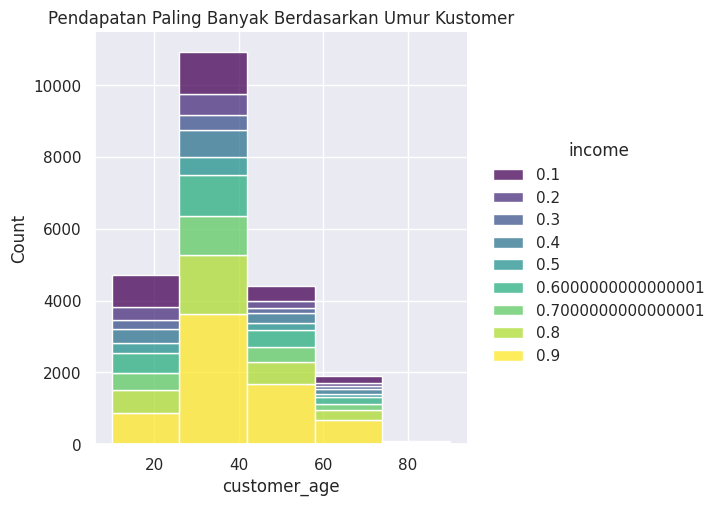

In [17]:
sns.displot(
    data=df, 
    bins=5, 
    x="customer_age", 
    hue="income", 
    multiple="stack", 
    palette="viridis").set(title="Pendapatan Paling Banyak Berdasarkan Umur Kustomer");

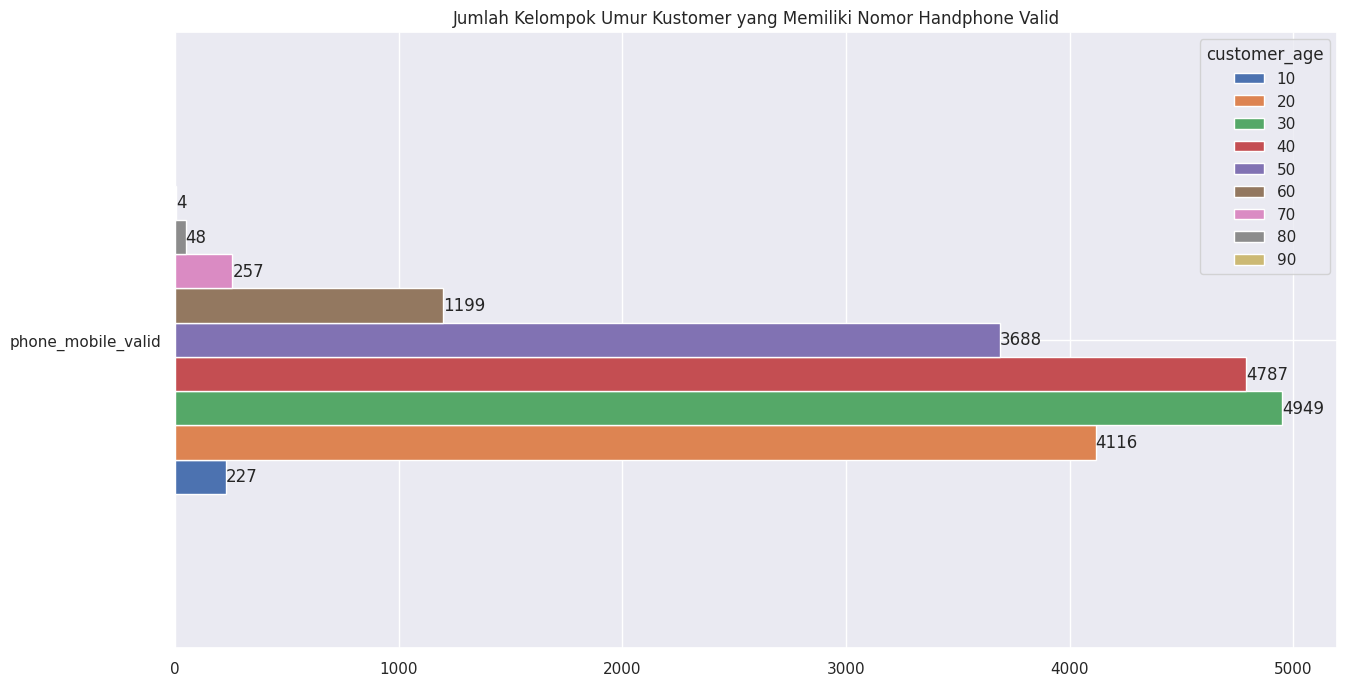

In [18]:
plot = pd.pivot_table(data=df, values="phone_mobile_valid", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Kelompok Umur Kustomer yang Memiliki Nomor Handphone Valid")

for container in ax.containers:
    ax.bar_label(container)

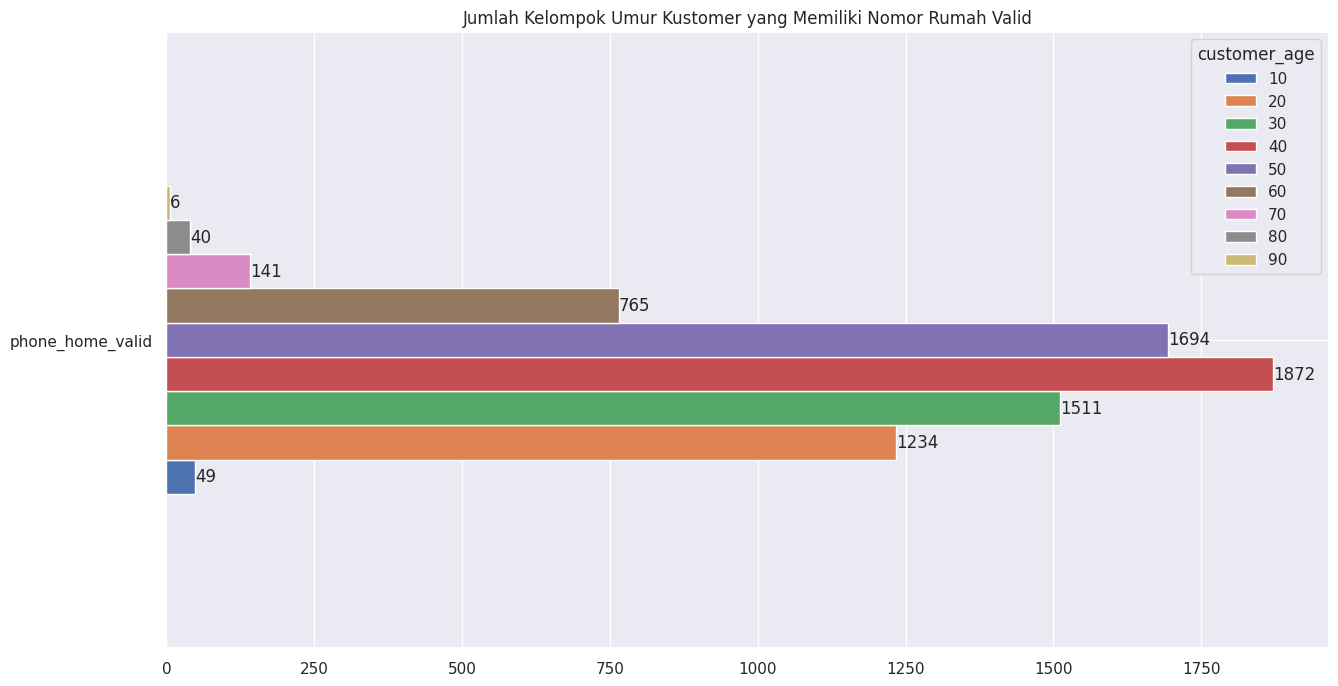

In [19]:
plot = pd.pivot_table(data=df, values="phone_home_valid", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Kelompok Umur Kustomer yang Memiliki Nomor Rumah Valid")

for container in ax.containers:
    ax.bar_label(container)

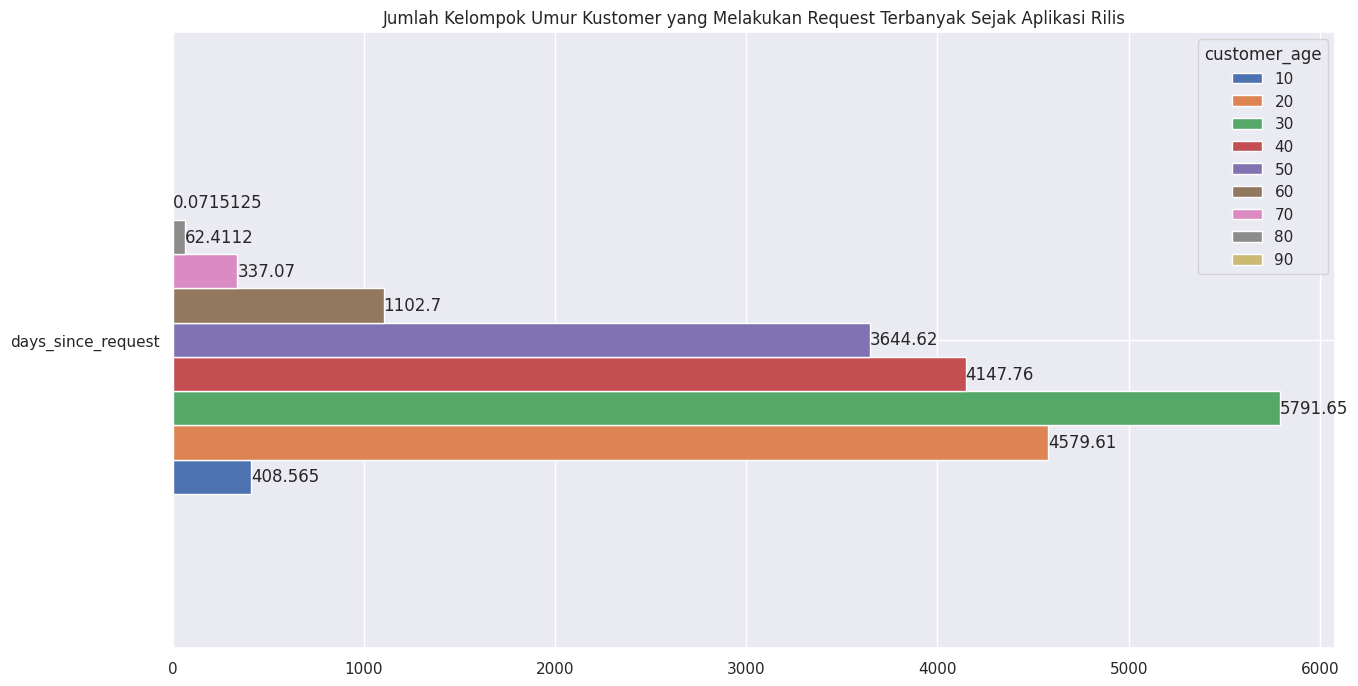

In [20]:
plot = pd.pivot_table(data=df, values="days_since_request", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Kelompok Umur Kustomer yang Melakukan Request Terbanyak Sejak Aplikasi Rilis")

for container in ax.containers:
    ax.bar_label(container)

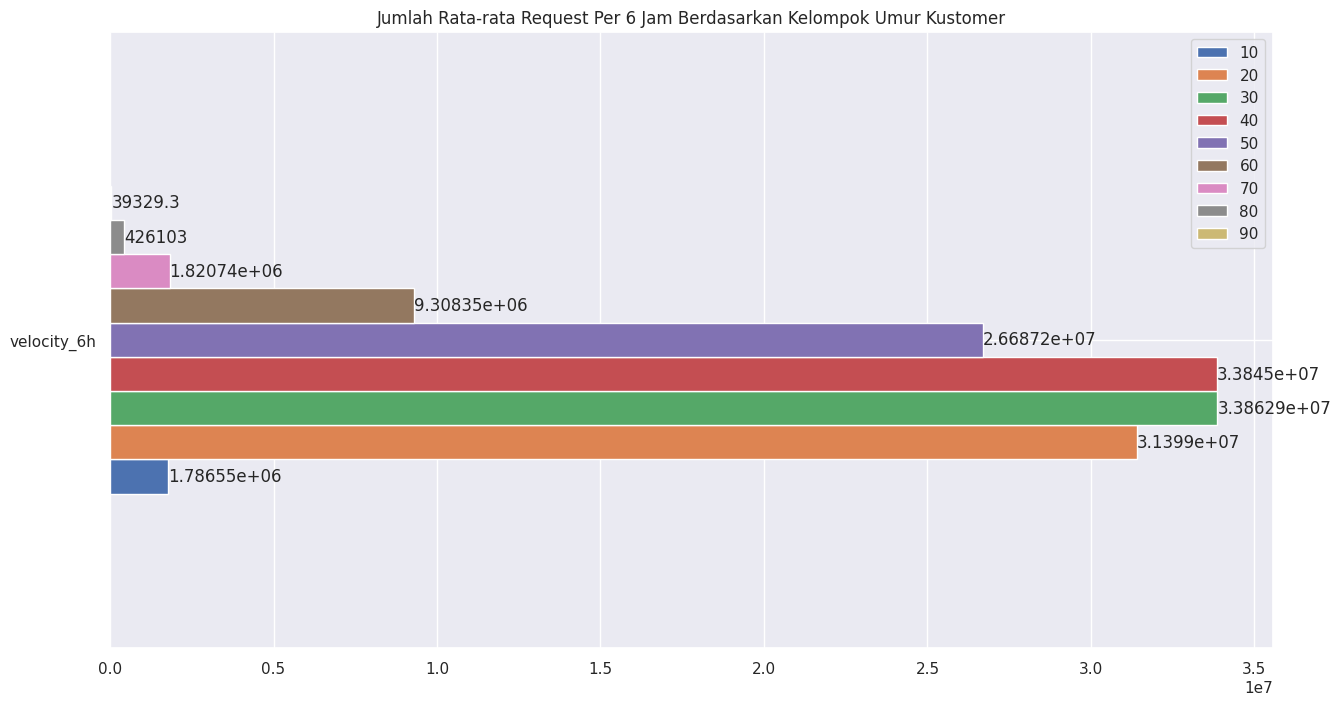

In [21]:
plot = pd.pivot_table(data=df, values="velocity_6h", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Rata-rata Request Per 6 Jam Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

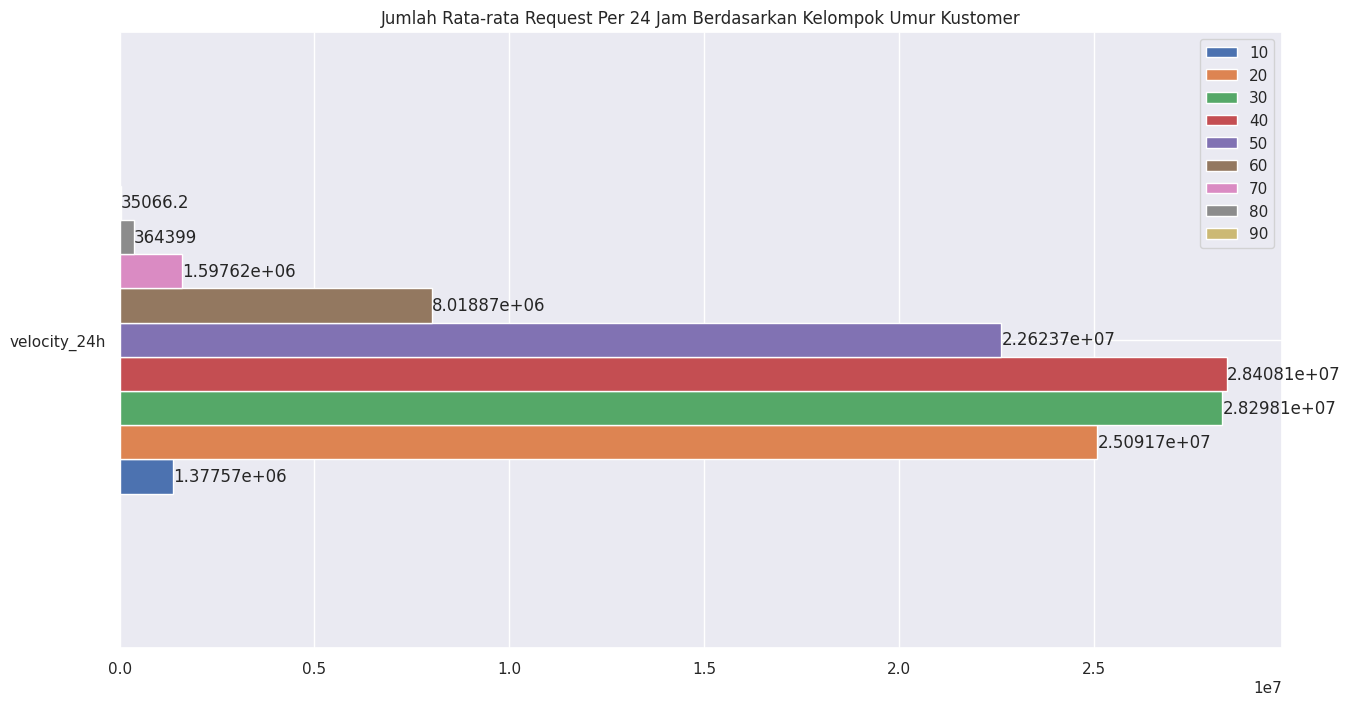

In [22]:
plot = pd.pivot_table(data=df, values="velocity_24h", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Rata-rata Request Per 24 Jam Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

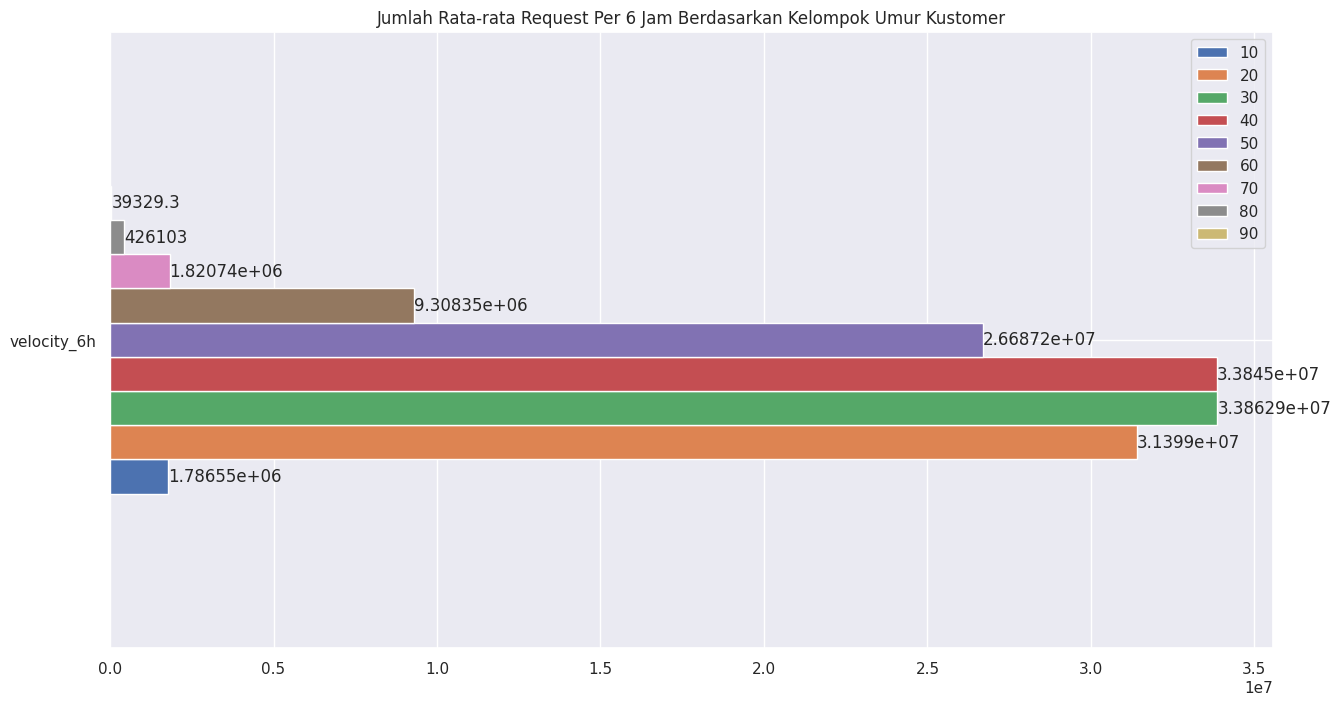

In [23]:
plot = pd.pivot_table(data=df, values="velocity_6h", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Rata-rata Request Per 6 Jam Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

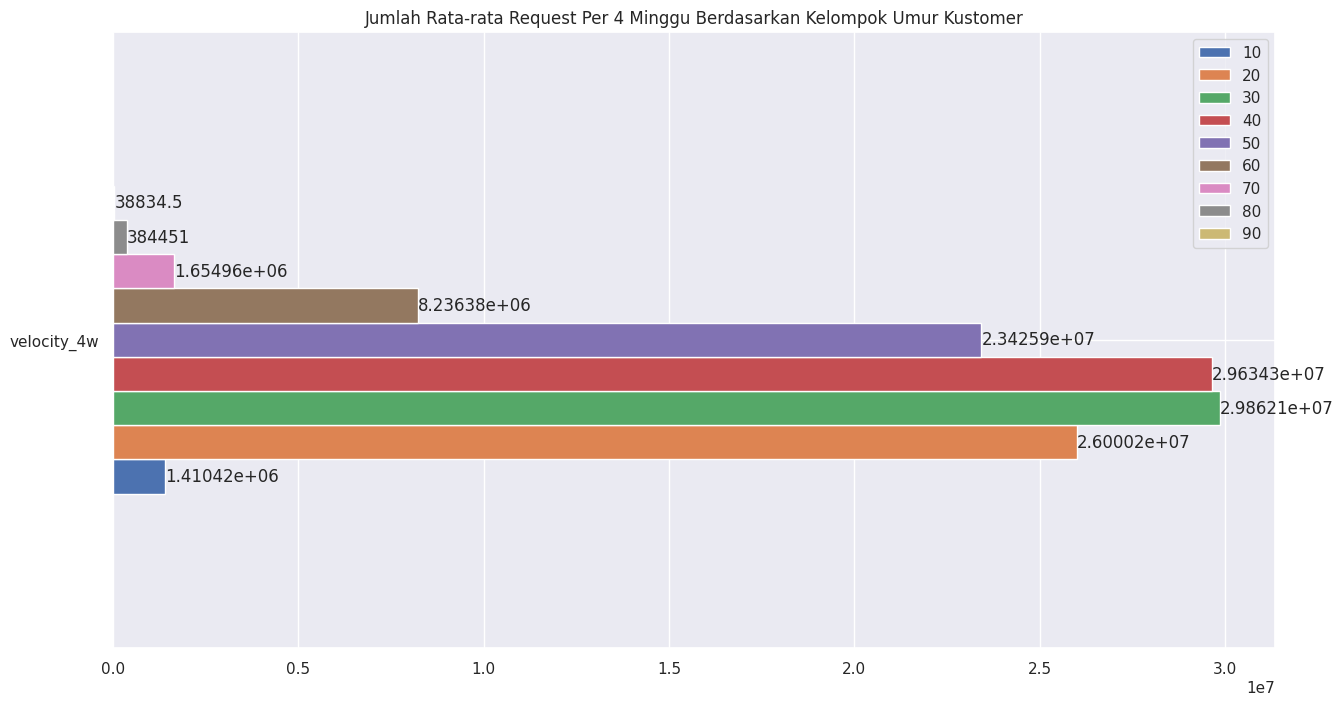

In [24]:
plot = pd.pivot_table(data=df, values="velocity_4w", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Rata-rata Request Per 4 Minggu Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

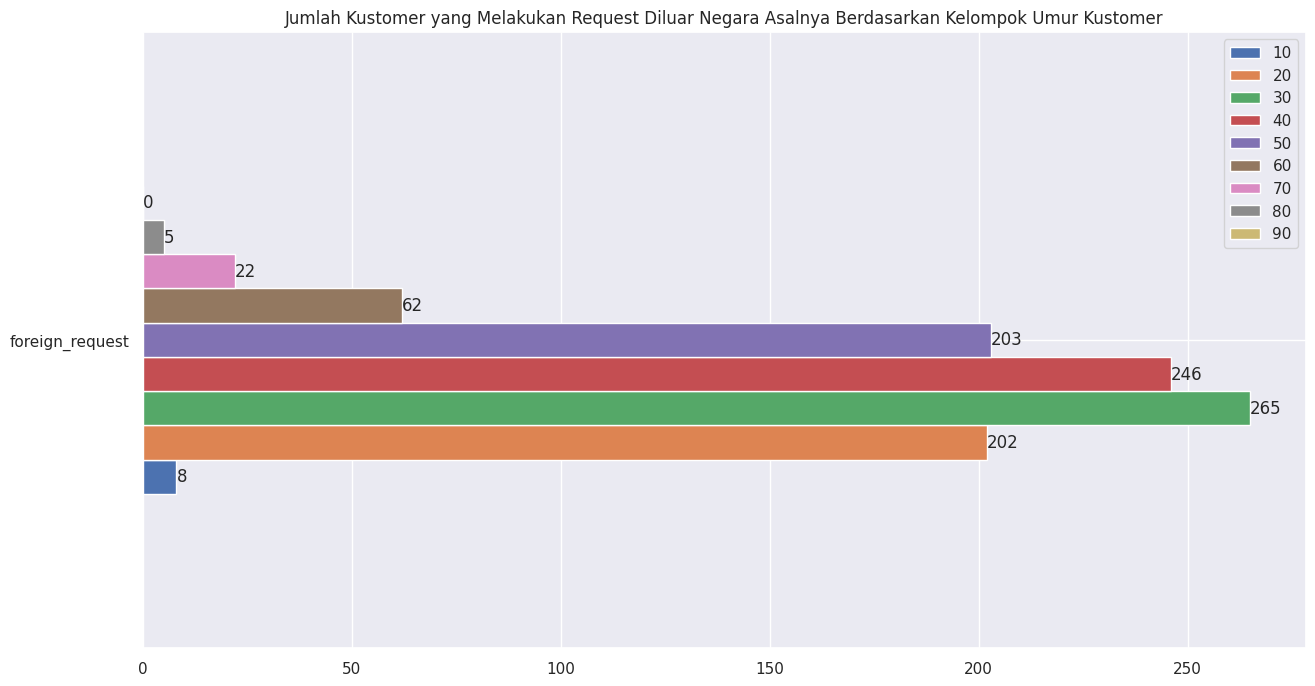

In [25]:
plot = pd.pivot_table(data=df, values="foreign_request", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Kustomer yang Melakukan Request Diluar Negara Asalnya Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


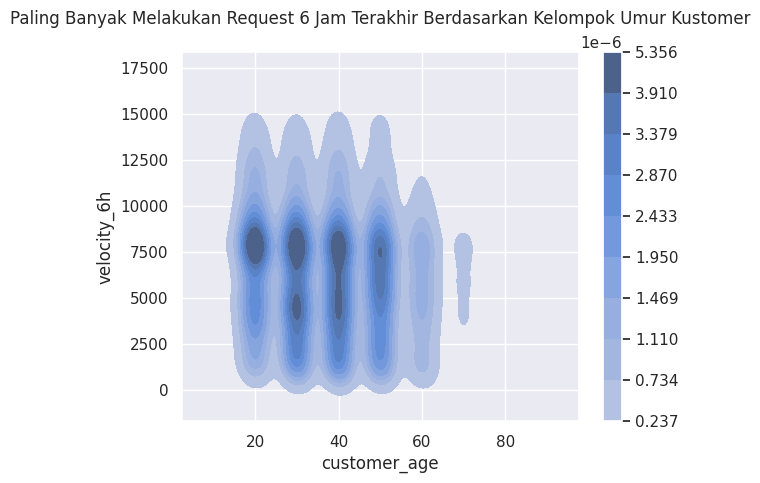

In [26]:
ax = sns.kdeplot(
    data=df,
    x="customer_age",
    y="velocity_6h",
    cbar=True,
    fill=True
)
ax.set_title(
    "Paling Banyak Melakukan Request 6 Jam Terakhir Berdasarkan Kelompok Umur Kustomer",
    pad=20  # Atur jarak
)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

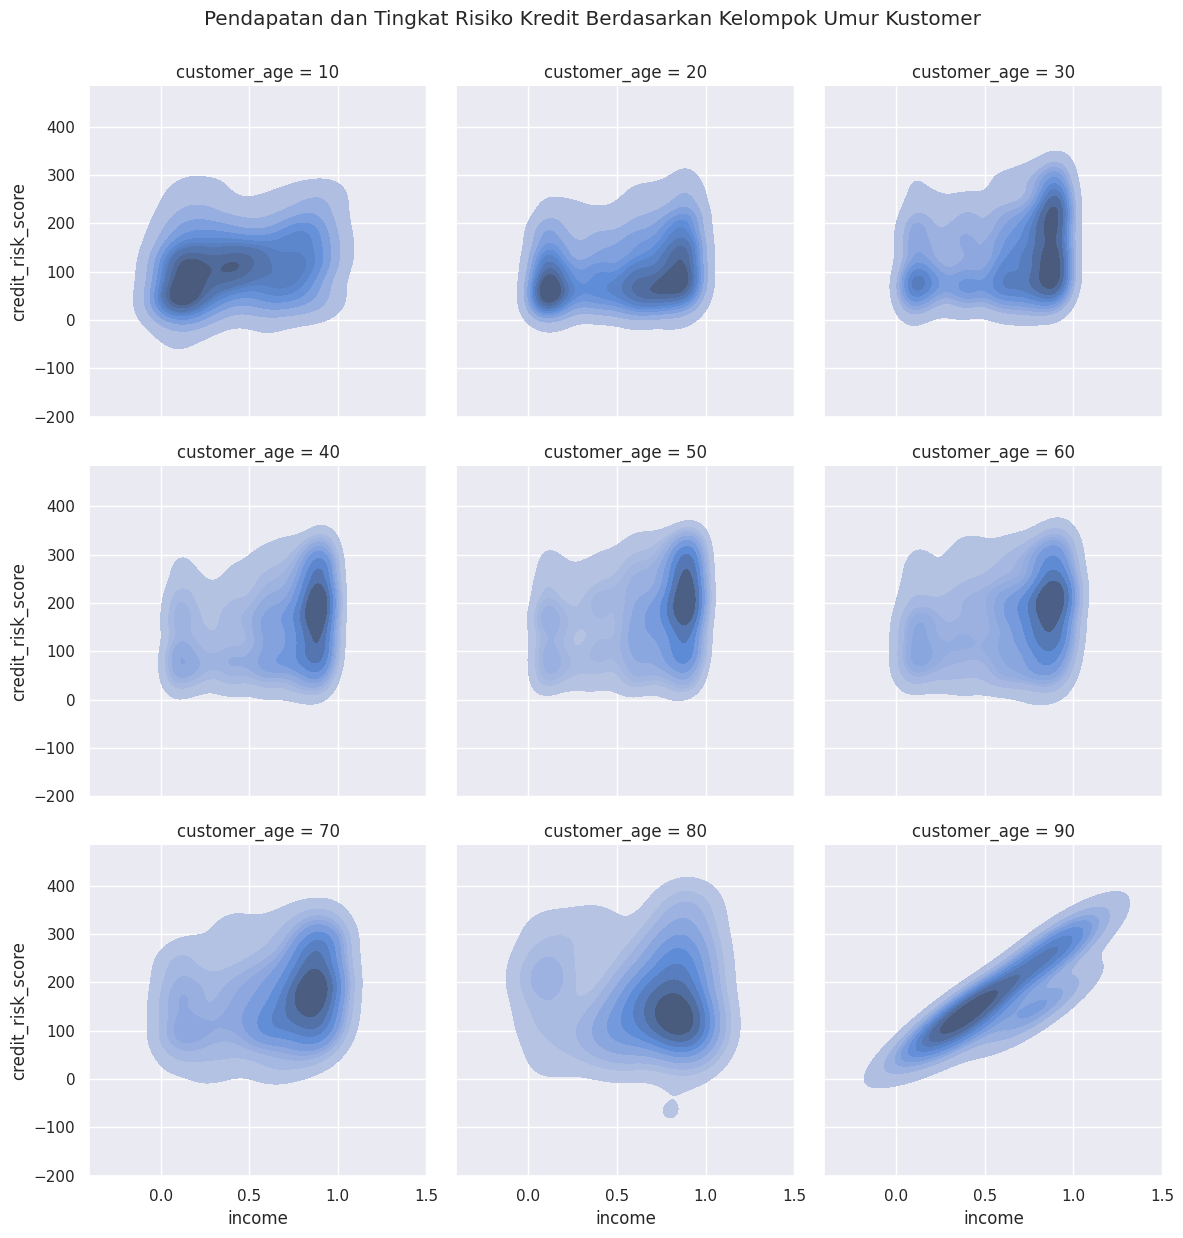

In [27]:
g = sns.FacetGrid(df, col="customer_age", height=4, col_wrap=3)
g.map(sns.kdeplot, "income", "credit_risk_score", fill=True)
g.figure.suptitle(
    "Pendapatan dan Tingkat Risiko Kredit Berdasarkan Kelompok Umur Kustomer",
    y=1.03,  # Atur posisi vertikal judul agar tidak menimpa judul subplot
);

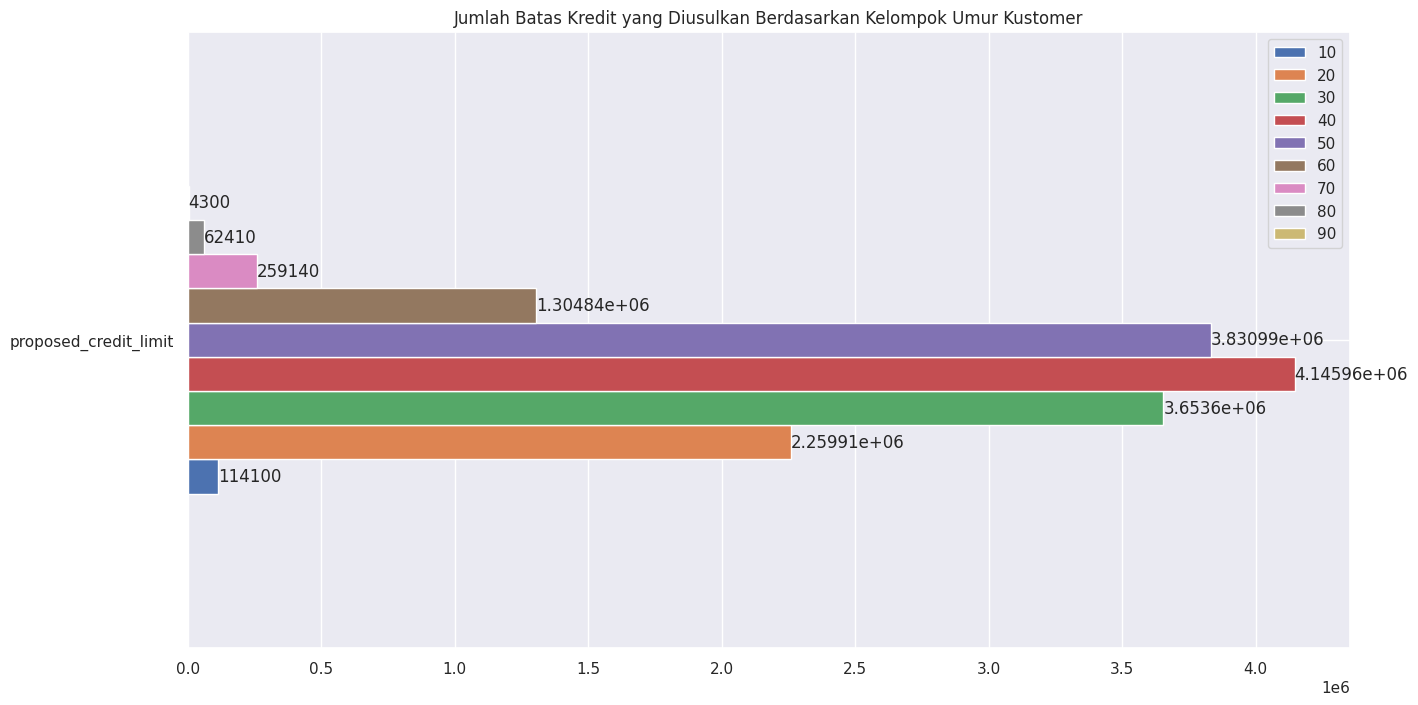

In [28]:
plot = pd.pivot_table(data=df, values="proposed_credit_limit", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Batas Kredit yang Diusulkan Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

In [29]:
pivot_table = pd.pivot_table(data=df, values="intended_balcon_amount", index="employment_status", columns="customer_age", aggfunc="sum")
pivot_table

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


customer_age,10,20,30,40,50,60,70,80,90
employment_status,,,,,,,,,
CA,2354.108195,28569.519277,28451.885727,27554.471796,20131.106703,4601.530971,875.510177,106.532891,-2.077591
CB,327.708086,6510.842446,9851.960717,8000.794251,4605.124762,1294.035688,230.249053,36.669793,33.348061
CC,-2.605335,231.471175,269.973423,317.945852,1443.480774,1702.593724,625.877223,131.398959,-3.516928
CD,113.092963,478.189602,899.286543,556.870303,567.637017,176.447926,-5.512348,NaN,NaN
CE,304.281837,2008.175614,868.867190,511.869401,618.373889,35.164075,84.517323,NaN,NaN
CF,51.608962,839.601296,1038.902859,1079.562857,655.212868,138.466101,93.787366,-1.234619,NaN
CG,NaN,-1.053055,-3.577143,-1.571154,-2.707396,20.092562,NaN,NaN,NaN


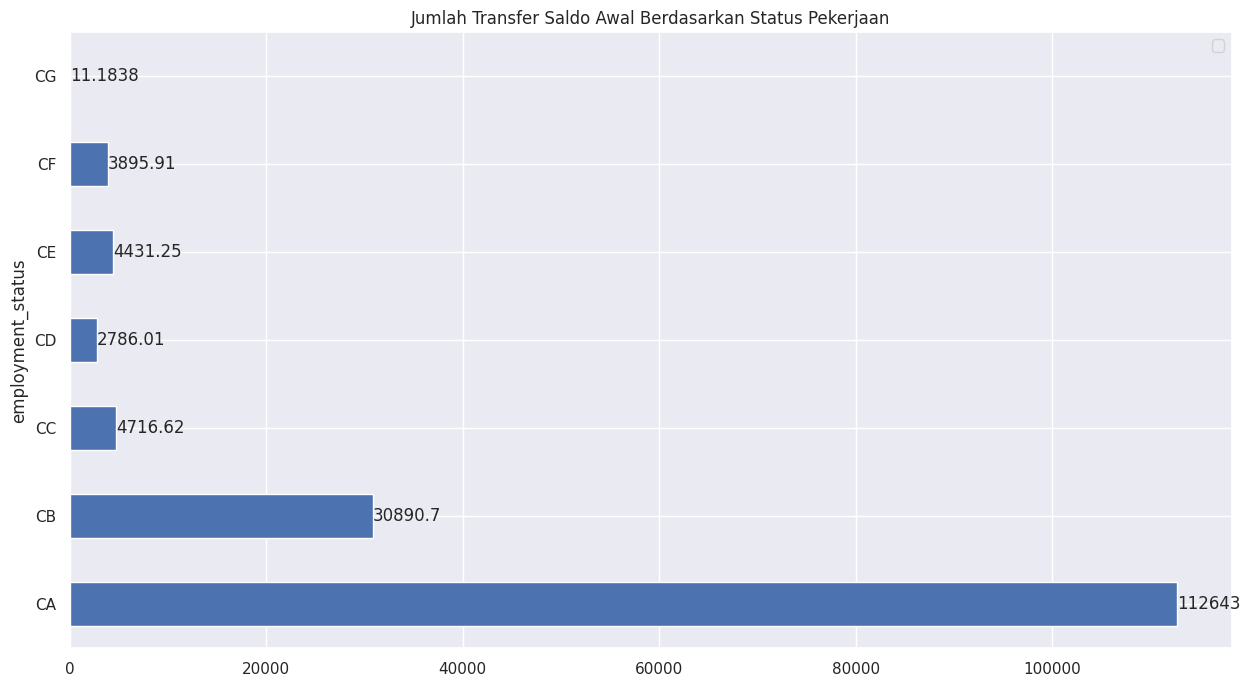

In [30]:
ax = pivot_table.sum(axis=1).plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Transfer Saldo Awal Berdasarkan Status Pekerjaan")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

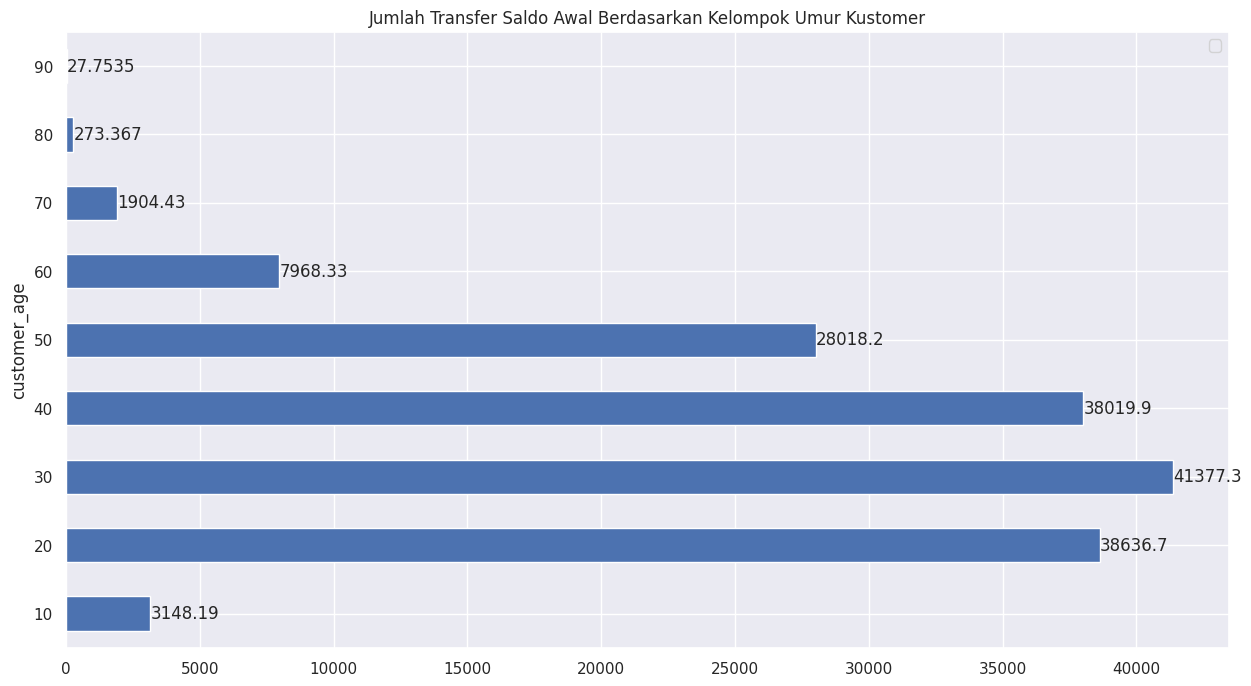

In [31]:
ax = pivot_table.sum(axis=0).plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Transfer Saldo Awal Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight


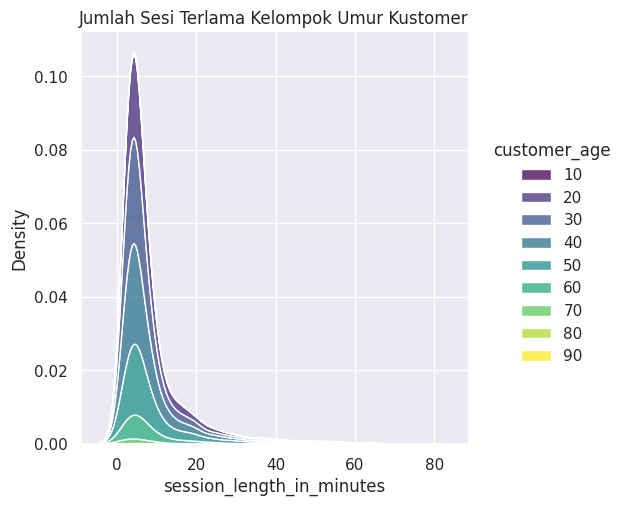

In [32]:
sns.displot(
    data=df,
    x="session_length_in_minutes",
    hue="customer_age",
    palette="viridis",
    multiple="stack",
    kind="kde")
plt.title("Jumlah Sesi Terlama Kelompok Umur Kustomer");

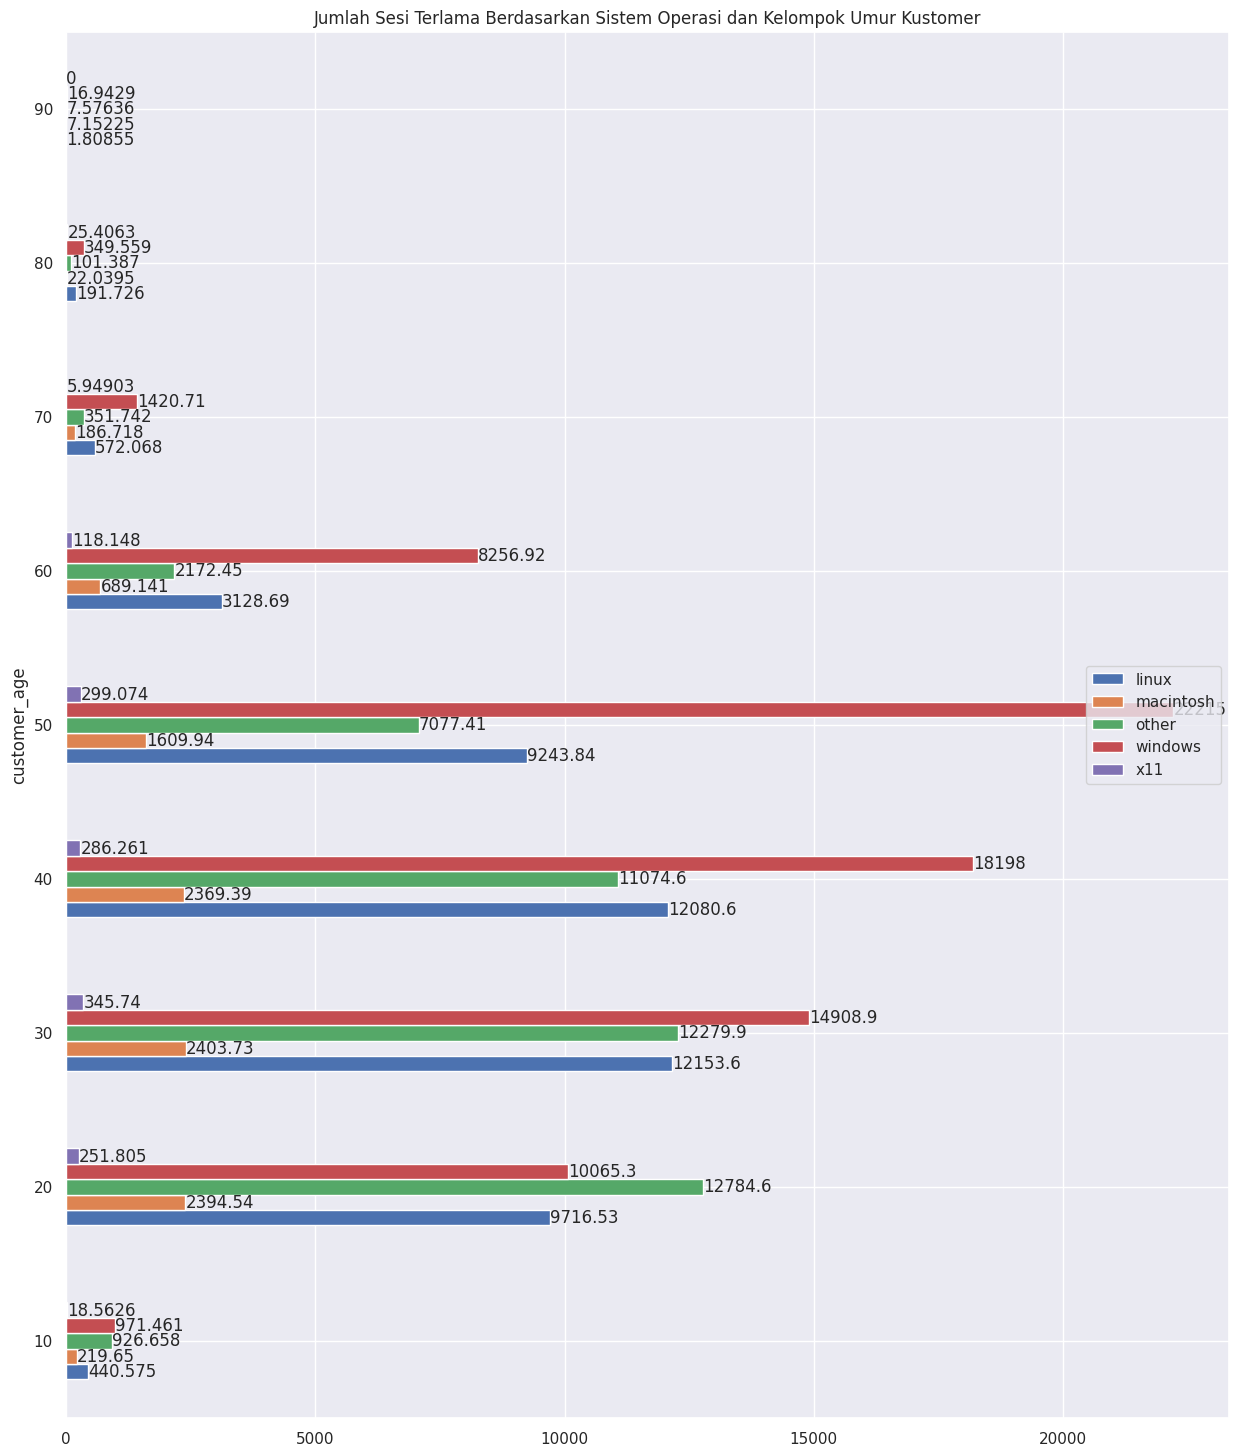

In [33]:
plot = df.groupby(["customer_age", "device_os"])["session_length_in_minutes"].sum().unstack()
ax = plot.plot.barh(figsize=(15, 18))
ax.set_title("Jumlah Sesi Terlama Berdasarkan Sistem Operasi dan Kelompok Umur Kustomer")
ax.legend(loc="center right")

for container in ax.containers:
    ax.bar_label(container)

# Data Preparation

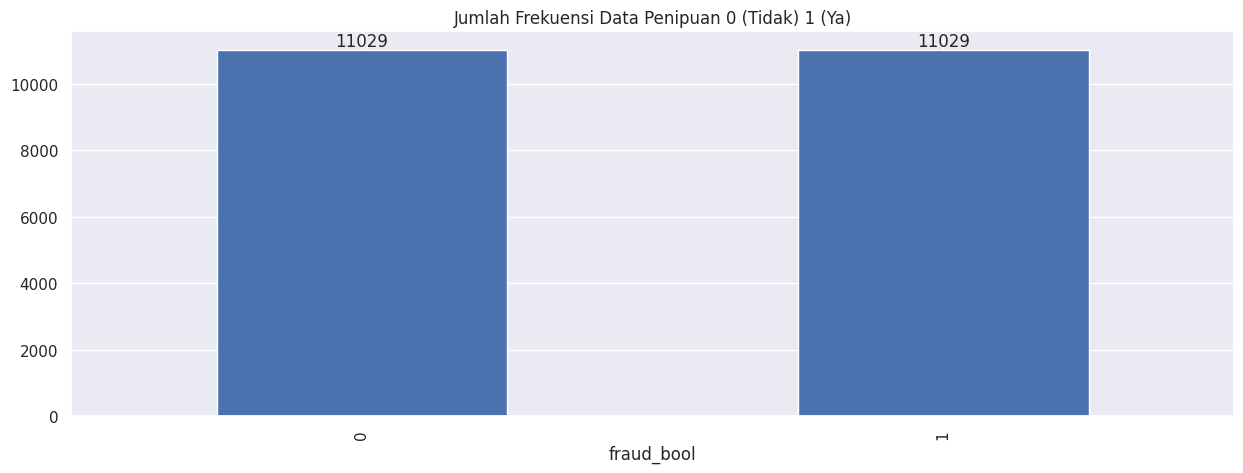

In [34]:
plot = df["fraud_bool"].value_counts()
ax = plot.plot.bar(figsize=(15, 5))
ax.set_title("Jumlah Frekuensi Data Penipuan 0 (Tidak) 1 (Ya)")

for container in ax.containers:
    ax.bar_label(container)

In [35]:
data_duplicated = df.duplicated().sum()
print(f"Jumlah data duplikat = {data_duplicated} data")

Jumlah data duplikat = 0 data


In [36]:
categorical_features

Index(['payment_type', 'employment_status', 'housing_status', 'source',
       'device_os'],
      dtype='object')

#### Encoding Category

In [37]:
for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
df

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,0,1059,...,0,1500.0,0,0,16.224843,0,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,3,1658,...,0,1500.0,0,0,3.363854,2,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,1,1095,...,0,200.0,0,0,22.730559,3,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,1,3483,...,0,200.0,0,0,15.215816,0,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,0,2339,...,0,200.0,0,0,3.743048,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22053,1,0.3,0.346834,-1,13,20,0.007084,-0.994025,2,692,...,0,200.0,0,0,23.525141,3,1,1,0,7
22054,1,0.7,0.161950,289,209,40,0.008195,-0.837462,2,679,...,0,2000.0,0,0,9.366778,3,0,1,0,7
22055,1,0.4,0.098119,-1,139,30,0.028858,-1.383748,1,345,...,0,500.0,0,0,2.363665,3,0,1,0,7
22056,1,0.8,0.830047,-1,73,40,0.009757,-1.439571,2,623,...,0,1900.0,0,0,1.596140,0,0,1,0,7


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


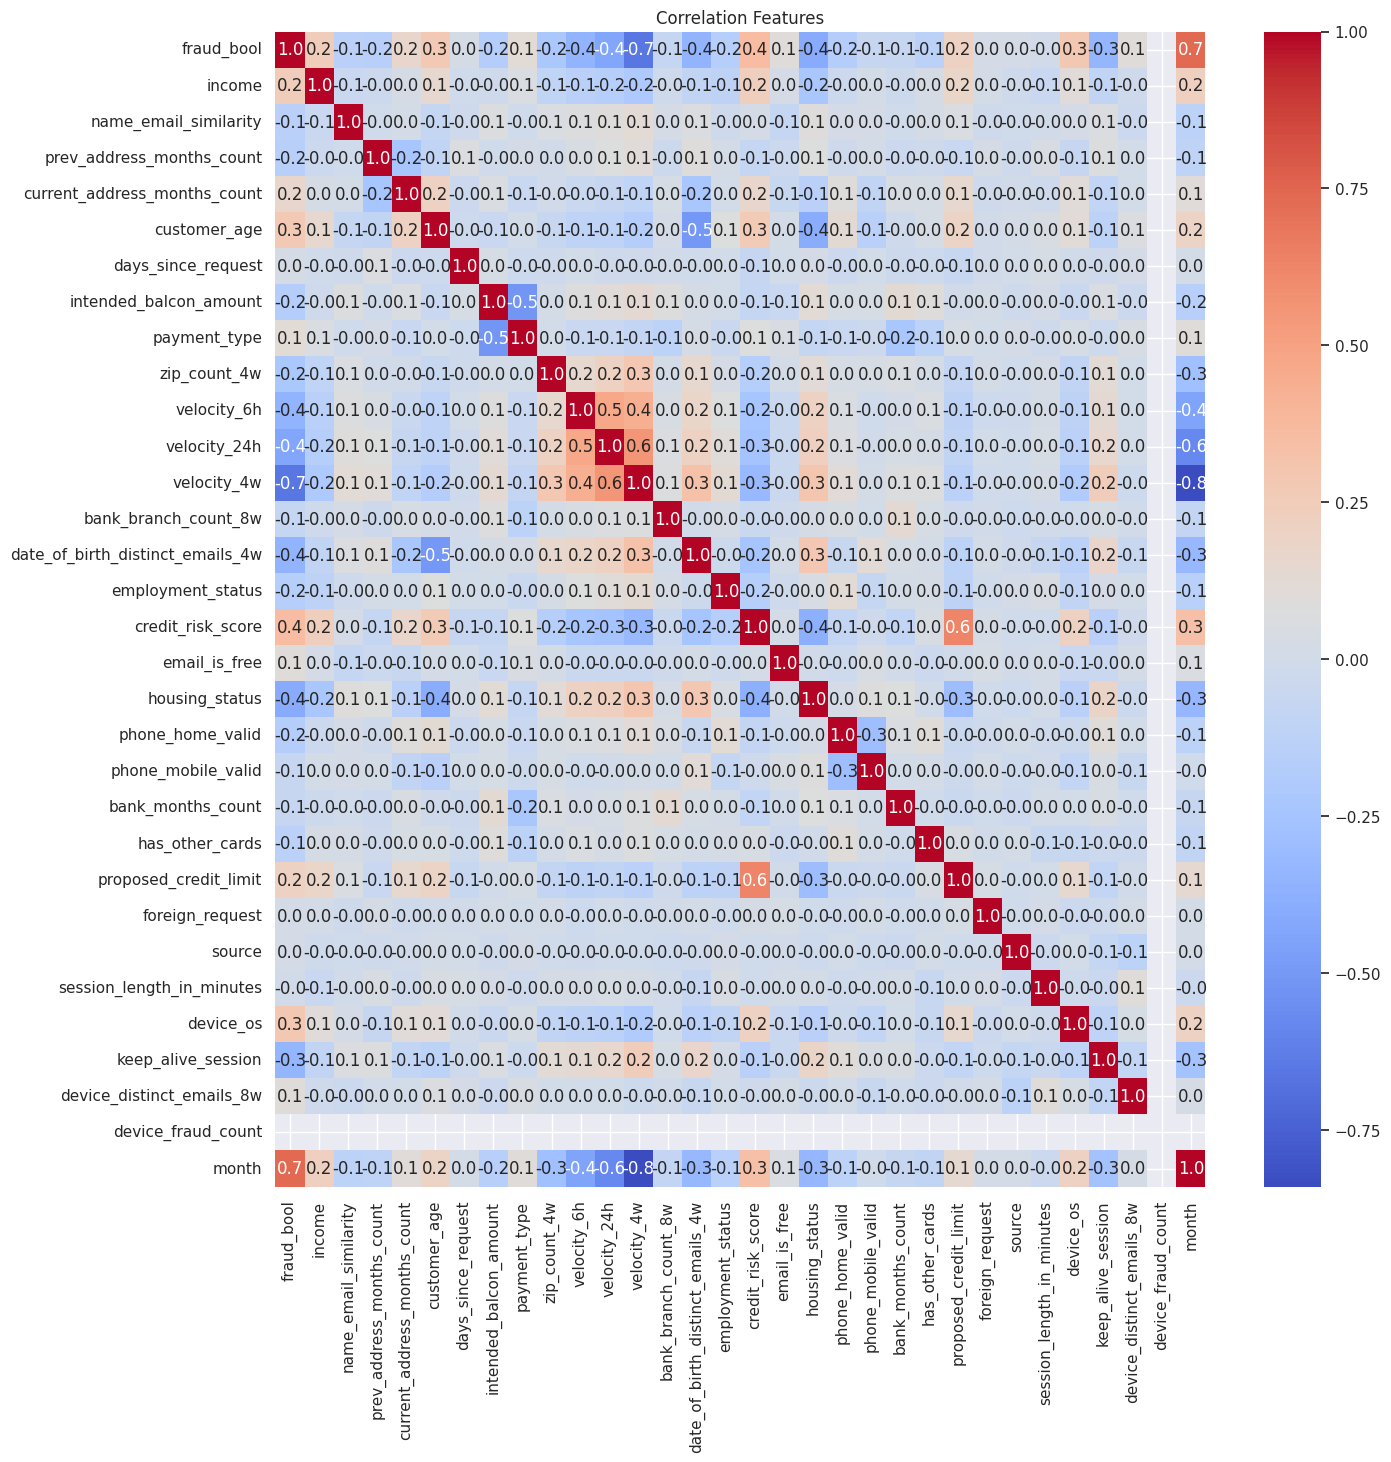

In [38]:
plt.figure(figsize=(15,15))
correlation = df.corr()
sns.heatmap(correlation, annot=True, cbar=True, cmap="coolwarm", fmt=".1f").set(title="Correlation Features");

In [39]:
df

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,0,1059,...,0,1500.0,0,0,16.224843,0,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,3,1658,...,0,1500.0,0,0,3.363854,2,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,1,1095,...,0,200.0,0,0,22.730559,3,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,1,3483,...,0,200.0,0,0,15.215816,0,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,0,2339,...,0,200.0,0,0,3.743048,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22053,1,0.3,0.346834,-1,13,20,0.007084,-0.994025,2,692,...,0,200.0,0,0,23.525141,3,1,1,0,7
22054,1,0.7,0.161950,289,209,40,0.008195,-0.837462,2,679,...,0,2000.0,0,0,9.366778,3,0,1,0,7
22055,1,0.4,0.098119,-1,139,30,0.028858,-1.383748,1,345,...,0,500.0,0,0,2.363665,3,0,1,0,7
22056,1,0.8,0.830047,-1,73,40,0.009757,-1.439571,2,623,...,0,1900.0,0,0,1.596140,0,0,1,0,7


# Modeling

In [40]:
X = df.iloc[:, 1:]
y_label = df["fraud_bool"]

#### Feature Extraction

##### Menggunakan VarianceThreshold

In [41]:
selector = VarianceThreshold(threshold=1)
X_selected = selector.fit_transform(X)

selected_features_vt = X.columns[selector.get_support()]
print("Jumlah fitur yang terpilih : ", selected_features_vt.size)
print("Fitur yang dipilih setelah Variance Thresholding:", selected_features_vt.tolist())

Jumlah fitur yang terpilih :  19
Fitur yang dipilih setelah Variance Thresholding: ['prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'employment_status', 'credit_risk_score', 'housing_status', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes', 'device_os', 'month']


##### Menggunakan SelectKBest

In [42]:
k_best = SelectKBest(score_func=f_classif, k=5)
k_best.fit(X, df['fraud_bool'])

selected_features_kbest = X.columns[k_best.get_support()]
print("Jumlah fitur yang terpilih : ", selected_features_kbest.size)
print("Fitur yang dipilih setelah SelectKBest:", selected_features_kbest.tolist())

Jumlah fitur yang terpilih :  5
Fitur yang dipilih setelah SelectKBest: ['velocity_24h', 'velocity_4w', 'credit_risk_score', 'housing_status', 'month']


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [29] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


##### Menggunakan Recursive Model Elimination (RFE)

In [43]:
model = RandomForestClassifier()

rfe_selector = RFE(model, n_features_to_select=5)
rfe_selector.fit_transform(X, df['fraud_bool'])

selected_features_rfe = X.columns[rfe_selector.get_support(indices=True)]
print("Jumlah fitur yang terpilih : ", selected_features_rfe.size)
print("Fitur yang dipilih dengan RFE:", selected_features_rfe.tolist())

Jumlah fitur yang terpilih :  5
Fitur yang dipilih dengan RFE: ['velocity_6h', 'velocity_24h', 'velocity_4w', 'housing_status', 'month']


In [44]:
def print_accuracy_with_result_feature_extraction():
    result = { 
            "Variance Thresholding": 0.0,
            "SelectKBest": 0.0,
            "RFE": 0.0
         }

    for method, selected_features in {
        "Variance Thresholding": selected_features_vt,
        "SelectKBest": selected_features_kbest,
        "RFE": selected_features_rfe
    }.items():
        df_selected = df[selected_features]
        # Tanpa PCA
        model = RandomForestClassifier()
        model.fit(df_selected, df["fraud_bool"])
        y_pred = model.predict(df_selected)
        acc = accuracy_score(df["fraud_bool"], y_pred)
        result[method] = acc
        print(f"Accuracy model random forest tanpa PCA = {result}")

In [45]:
print_accuracy_with_result_feature_extraction()

Accuracy model random forest tanpa PCA = {'Variance Thresholding': 0.9999546649741591, 'SelectKBest': 0.0, 'RFE': 0.0}
Accuracy model random forest tanpa PCA = {'Variance Thresholding': 0.9999546649741591, 'SelectKBest': 0.9998639949224771, 'RFE': 0.0}
Accuracy model random forest tanpa PCA = {'Variance Thresholding': 0.9999546649741591, 'SelectKBest': 0.9998639949224771, 'RFE': 1.0}


In [46]:
df = df[selected_features_kbest]
df

,velocity_24h,velocity_4w,credit_risk_score,housing_status,month
0,7850.955007,6742.080561,163,2,0
1,5745.251481,5941.664859,154,2,0
2,5471.988958,5992.555113,89,2,0
3,6755.344479,5970.336831,90,2,0
4,5124.046930,5940.734212,91,2,0
...,...,...,...,...,...
22053,3048.936631,3008.145870,48,0,7
22054,2867.661501,3123.982404,272,0,7
22055,3928.932950,3026.587206,158,0,7
22056,2925.272333,3077.924174,295,0,7


In [47]:
numerical_features = df

#### Outlier

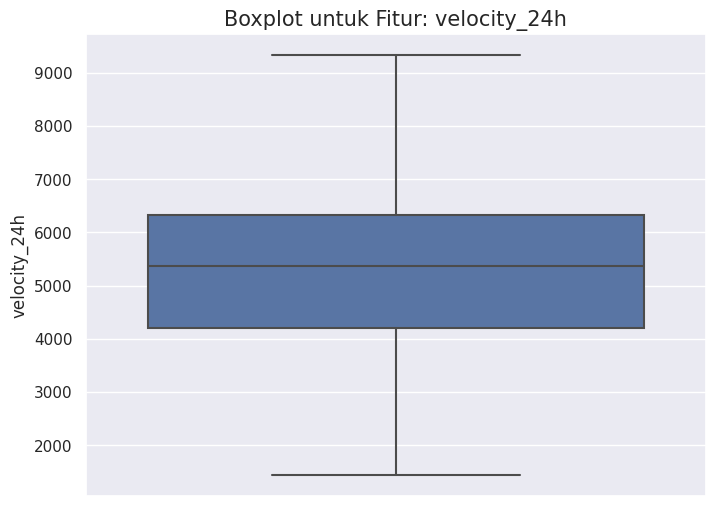

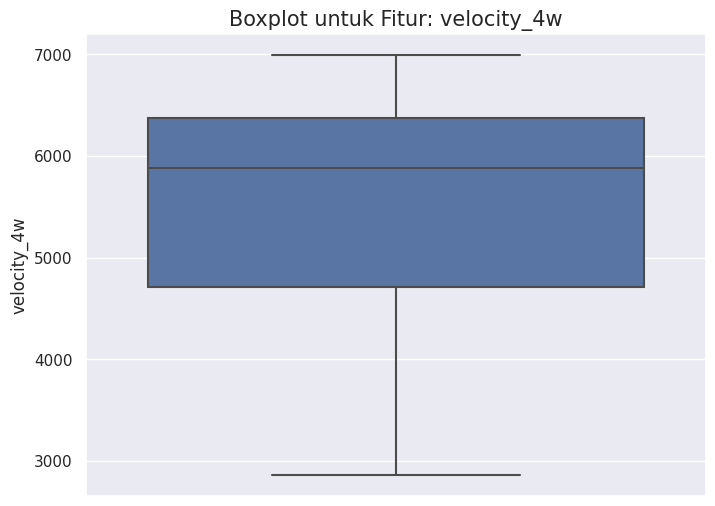

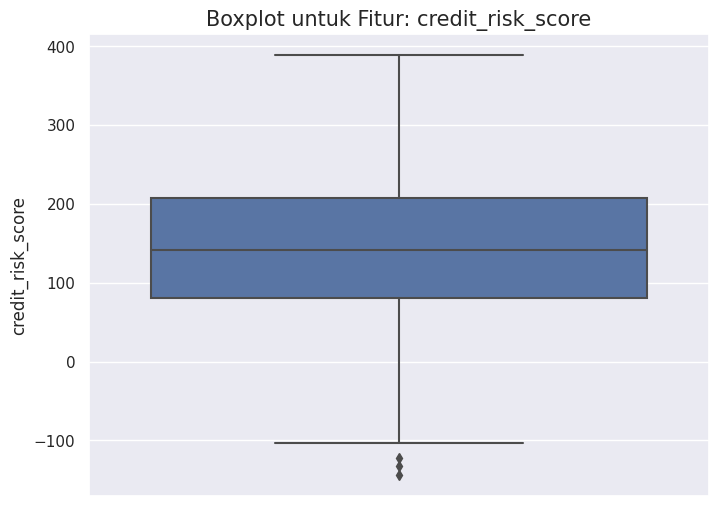

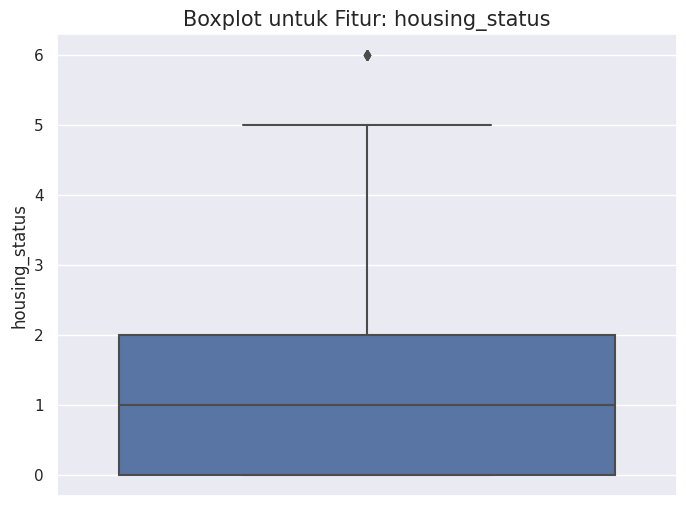

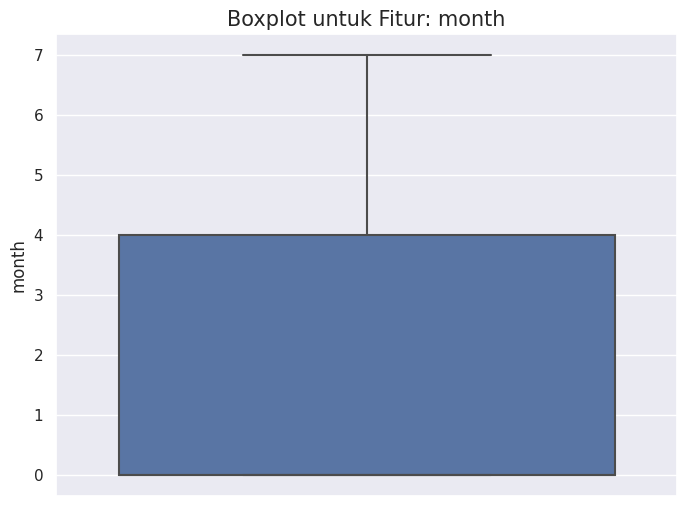

In [48]:
for col in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, y=col)
    plt.title(f"Boxplot untuk Fitur: {col}", fontsize=15)
    plt.show()

In [49]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

In [50]:
categorical_features

Index([], dtype='object')

In [51]:
numerical_features

Index(['velocity_24h', 'velocity_4w', 'credit_risk_score', 'housing_status',
       'month'],
      dtype='object')

In [52]:
def print_counts_numerical_features(df):
    for col in numerical_features:
        plt.figure(figsize=(8, 5))
        plt.boxplot(data=df, x=col)
        plt.title(f'{col}')
        plt.show()

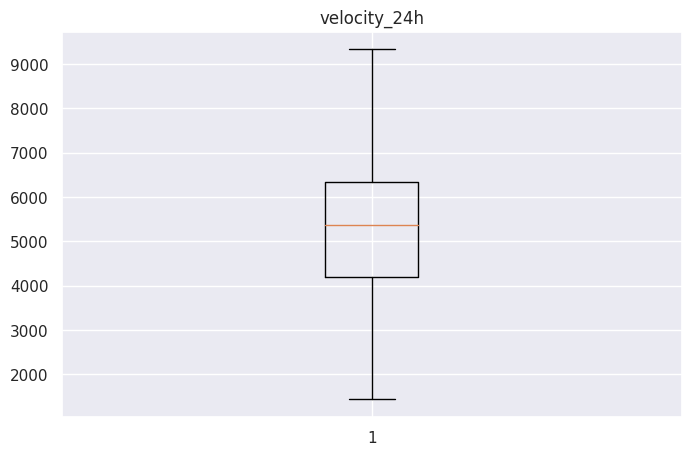

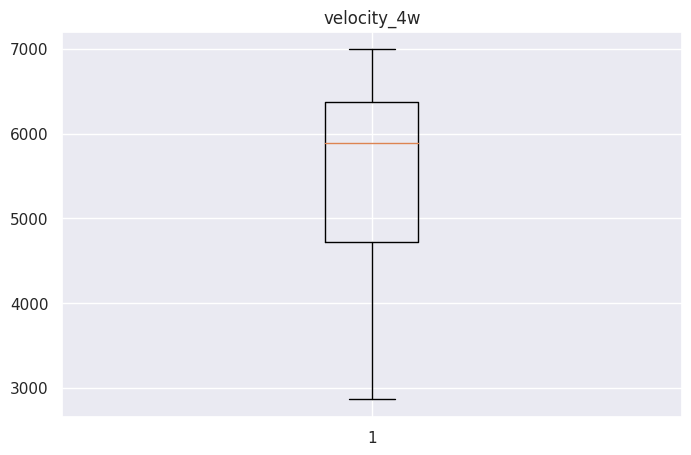

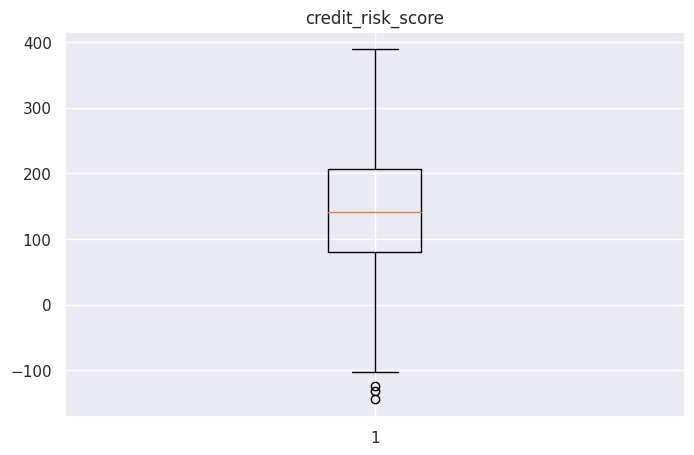

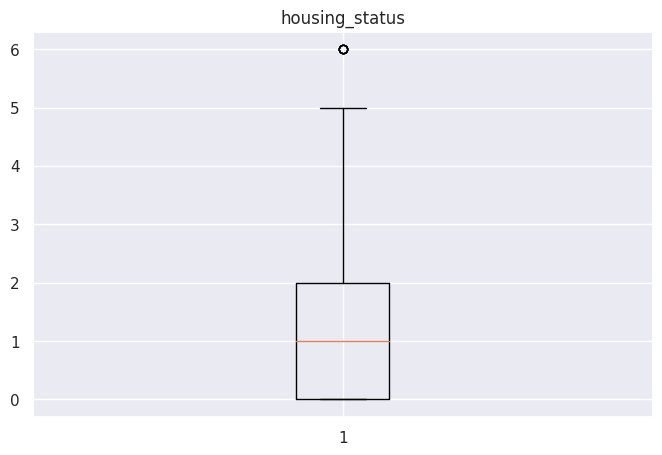

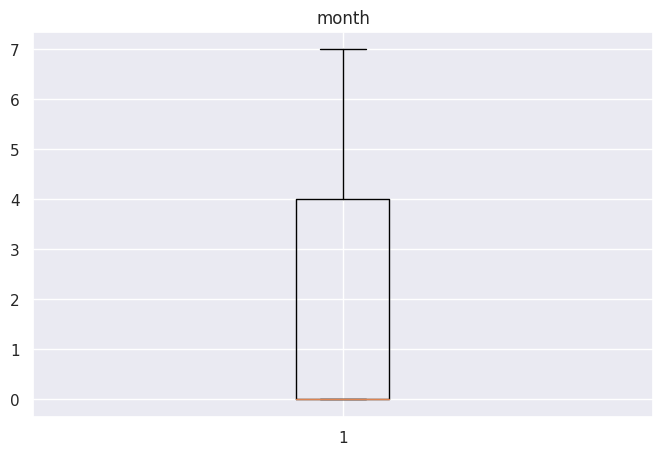

In [53]:
print_counts_numerical_features(df)

In [54]:
numerical_features

Index(['velocity_24h', 'velocity_4w', 'credit_risk_score', 'housing_status',
       'month'],
      dtype='object')

In [55]:
Q1 = df["velocity_24h"].quantile(0.25)
Q3 = df["velocity_24h"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df["velocity_24h"] >= lower_bound) & (df["velocity_24h"] <= upper_bound)]
print(f"Jumlah data setelah menghapus outlier: {len(df)} data")


Jumlah data setelah menghapus outlier: 22058 data


<Axes: xlabel='velocity_24h'>

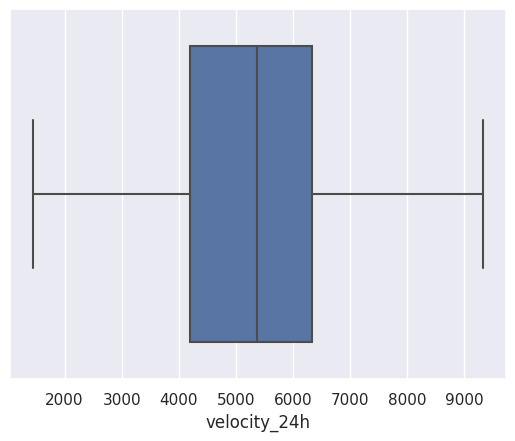

In [56]:
sns.boxplot(data=df, x="velocity_24h")

In [57]:
Q1 = df["velocity_4w"].quantile(0.25)
Q3 = df["velocity_4w"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df["velocity_4w"] >= lower_bound) & (df["velocity_4w"] <= upper_bound)]
print(f"Jumlah data setelah menghapus outlier: {len(df)} data")


Jumlah data setelah menghapus outlier: 22058 data


<Axes: xlabel='velocity_4w'>

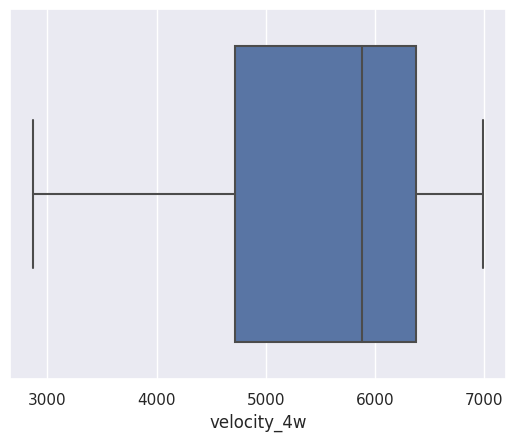

In [58]:
sns.boxplot(data=df, x="velocity_4w")

In [59]:
df_clean = pd.concat([df, y_label], axis=1)
df_clean = df_clean.dropna()
df_clean

,velocity_24h,velocity_4w,credit_risk_score,housing_status,month,fraud_bool
0,7850.955007,6742.080561,163,2,0,0
1,5745.251481,5941.664859,154,2,0,0
2,5471.988958,5992.555113,89,2,0,0
3,6755.344479,5970.336831,90,2,0,0
4,5124.046930,5940.734212,91,2,0,0
...,...,...,...,...,...,...
22053,3048.936631,3008.145870,48,0,7,1
22054,2867.661501,3123.982404,272,0,7,1
22055,3928.932950,3026.587206,158,0,7,1
22056,2925.272333,3077.924174,295,0,7,1


In [60]:
df_clean.describe()

,velocity_24h,velocity_4w,credit_risk_score,housing_status,month,fraud_bool
count,22058.000000,22058.000000,22058.000000,22058.000000,22058.000000,22058.000000
mean,5250.480818,5469.561787,147.368483,1.376598,1.782981,0.500000
std,1473.431226,1091.723820,82.650230,1.344544,2.419059,0.500011
min,1440.568313,2863.783336,-144.000000,0.000000,0.000000,0.000000
25%,4194.597269,4716.808573,81.000000,0.000000,0.000000,0.000000
50%,5363.138097,5884.606807,141.000000,1.000000,0.000000,0.500000
75%,6333.391065,6377.548195,207.000000,2.000000,4.000000,1.000000
max,9333.536173,6994.764201,389.000000,6.000000,7.000000,1.000000


In [61]:
X = df_clean.iloc[:, :5]
y = df_clean["fraud_bool"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(f"X_train = {X_train.shape}, X_test = {X_test.shape}, y_train = {y_train.shape}, y_test = {y_test.shape}")

X_train = (17646, 5), X_test = (4412, 5), y_train = (17646,), y_test = (4412,)


In [62]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[ 0.51097105,  1.17090858,  1.08308427, -0.28039643, -0.73778185],
       [-0.1235879 , -1.13090493, -1.78116454,  1.94904578, -0.73778185],
       [-0.46207037,  0.80506426, -0.59679161,  0.46275097, -0.73778185],
       ...,
       [-0.52803791, -1.1501608 ,  0.98640077, -1.02354384,  0.91472962],
       [ 0.04615756, -0.64783817, -0.35508285, -1.02354384,  0.50160176],
       [-1.89369736, -1.17287438,  0.17667642, -1.02354384,  1.74098536]])

In [63]:
X_test_scaled

array([[ 1.55279205,  1.2822167 , -1.08020914,  1.94904578, -0.73778185],
       [ 0.13781072, -1.3892917 , -1.08020914,  1.94904578, -0.73778185],
       [-0.86333594, -0.58144631, -0.29465566,  0.46275097, -0.73778185],
       ...,
       [ 0.25986117,  0.6898298 ,  0.66009394,  0.46275097, -0.73778185],
       [ 1.314312  ,  0.44635287,  1.09516971, -1.02354384, -0.73778185],
       [ 1.17482393,  0.75445453,  2.06200475,  0.46275097, -0.73778185]])

In [64]:
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [65]:
y_pred_val = model.predict(X_test_scaled)
y_pred_val

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
y_pred_train = model.predict(X_train_scaled)
y_pred_train

array([0, 0, 0, ..., 1, 1, 1])

In [67]:
pd.DataFrame({
    "aktual": y_test,
    "prediksi": y_pred_val
}).sample(20)

,aktual,prediksi
21928,1,1
13844,1,1
354,0,0
12066,1,0
15610,1,1
8339,0,0
17203,1,1
9967,0,0
15817,1,1
543,0,0


# Evaluate

In [68]:
acc_train = accuracy_score(y_train, y_pred_train)
acc_val = accuracy_score(y_test, y_pred_val)
print(f"Accuracy model random forest training = {acc_train}")
print(f"Accuracy model random forest validation = {acc_val}")

Accuracy model random forest training = 1.0
Accuracy model random forest validation = 0.9310970081595649


In [69]:
report = classification_report(y_test, y_pred_val)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2208
           1       0.98      0.88      0.93      2204

    accuracy                           0.93      4412
   macro avg       0.94      0.93      0.93      4412
weighted avg       0.94      0.93      0.93      4412



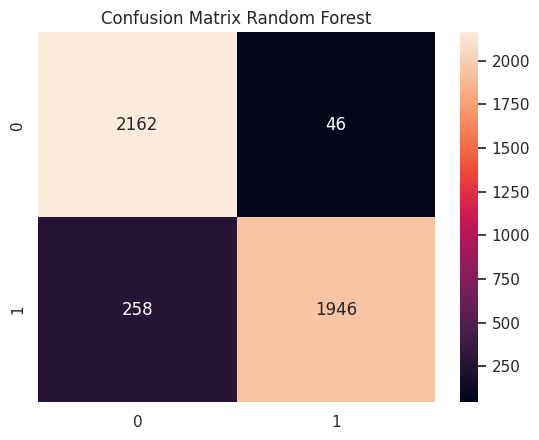

In [70]:
# Pola 
# | TP  | FP |
# | FN  | TN |
con_mat = confusion_matrix(y_test, y_pred_val)
sns.heatmap(con_mat, annot=True, fmt=".5g").set(title="Confusion Matrix Random Forest");

In [71]:
# Evaluate Cross Validation
def cross_validation(n_splits, model):
    acc = 0
    precision = 0
    recall = 0
    f1_score = 0
    kf = StratifiedKFold(n_splits=n_splits)

    for fold, (train, val) in enumerate(kf.split(X=X_train_scaled, y=y_train)):
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        print(f"The fold is : {fold} : ")
        report = classification_report(y_test, y_pred)
        report_dict = classification_report(y_test, y_pred, output_dict=True)
        print(report)
        roc_acc = roc_auc_score(y_test, y_pred)
        acc += roc_acc
        precision += report_dict["macro avg"]["precision"]
        recall += report_dict["macro avg"]["recall"]
        f1_score += report_dict["macro avg"]["f1-score"]
        print(f"The accuracy for fold {fold+1} : {roc_acc}")
        
    acc = acc / n_splits
    precision = precision / n_splits
    recall = recall / n_splits
    f1_score = f1_score / n_splits
    print(f"Average result accuracy model {model} is {acc}")
    print(f"Average result precision model {model} is {precision}")
    print(f"Average result recall model {model} is {recall}")
    print(f"Average result f1_score model {model} is {f1_score}")
    return f"{model}", acc, precision, recall, f1_score

In [72]:
# Cross validation RandomForestClassifier model
model = RandomForestClassifier()
rf_model, rf_acc, rf_precision, rf_recall, rf_f1_score = cross_validation(5, model)

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2208
           1       0.98      0.88      0.93      2204

    accuracy                           0.93      4412
   macro avg       0.93      0.93      0.93      4412
weighted avg       0.93      0.93      0.93      4412

The accuracy for fold 1 : 0.9299203194455404
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.89      0.98      0.94      2208
           1       0.98      0.88      0.93      2204

    accuracy                           0.93      4412
   macro avg       0.94      0.93      0.93      4412
weighted avg       0.94      0.93      0.93      4412

The accuracy for fold 2 : 0.9319595958599648
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2208
           1       0.98      0.88      0.93      2204

    accuracy                       

In [73]:
# Cross validation LogisticRegression model
model = LogisticRegression()
lr_model, lr_acc, lr_precision, lr_recall, lr_f1_score = cross_validation(5, model)

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2208
           1       1.00      0.87      0.93      2204

    accuracy                           0.93      4412
   macro avg       0.94      0.93      0.93      4412
weighted avg       0.94      0.93      0.93      4412

The accuracy for fold 1 : 0.9346642468239564
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2208
           1       1.00      0.87      0.93      2204

    accuracy                           0.93      4412
   macro avg       0.94      0.93      0.93      4412
weighted avg       0.94      0.93      0.93      4412

The accuracy for fold 2 : 0.9346642468239564
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2208
           1       1.00      0.87      0.93      2204

    accuracy                       

In [74]:
# Cross validation NaiveBayes model
model = GaussianNB()
nb_model, nb_acc, nb_precision, nb_recall, nb_f1_score = cross_validation(5, model)

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2208
           1       1.00      0.87      0.93      2204

    accuracy                           0.93      4412
   macro avg       0.94      0.93      0.93      4412
weighted avg       0.94      0.93      0.93      4412

The accuracy for fold 1 : 0.9337588607012284
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2208
           1       1.00      0.87      0.93      2204

    accuracy                           0.93      4412
   macro avg       0.94      0.93      0.93      4412
weighted avg       0.94      0.93      0.93      4412

The accuracy for fold 2 : 0.9337588607012284
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2208
           1       1.00      0.87      0.93      2204

    accuracy                       

In [75]:
# Cross validation SVC model
model = SVC()
svc_model, svc_acc, svc_precision, svc_recall, svc_f1_score = cross_validation(5, model)

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2208
           1       1.00      0.87      0.93      2204

    accuracy                           0.93      4412
   macro avg       0.94      0.93      0.93      4412
weighted avg       0.94      0.93      0.93      4412

The accuracy for fold 1 : 0.9346642468239564
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2208
           1       1.00      0.87      0.93      2204

    accuracy                           0.93      4412
   macro avg       0.94      0.93      0.93      4412
weighted avg       0.94      0.93      0.93      4412

The accuracy for fold 2 : 0.9346642468239564
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2208
           1       1.00      0.87      0.93      2204

    accuracy                       

In [76]:
# Cross validation KNClassifier model
model = KNeighborsClassifier()
kn_model, kn_acc, kn_precision, kn_recall, kn_f1_score = cross_validation(5, model)

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2208
           1       0.96      0.88      0.92      2204

    accuracy                           0.92      4412
   macro avg       0.93      0.92      0.92      4412
weighted avg       0.93      0.92      0.92      4412

The accuracy for fold 1 : 0.9219892520844841
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2208
           1       0.96      0.88      0.92      2204

    accuracy                           0.92      4412
   macro avg       0.93      0.92      0.92      4412
weighted avg       0.93      0.92      0.92      4412

The accuracy for fold 2 : 0.9219892520844841
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2208
           1       0.96      0.88      0.92      2204

    accuracy                       

In [77]:
# Cross validation DecisionTree model
model = DecisionTreeClassifier()
dt_model, dt_acc, dt_precision, dt_recall, dt_f1_score = cross_validation(5, model)

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2208
           1       0.89      0.90      0.89      2204

    accuracy                           0.89      4412
   macro avg       0.89      0.89      0.89      4412
weighted avg       0.89      0.89      0.89      4412

The accuracy for fold 1 : 0.8909854283384625
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2208
           1       0.89      0.90      0.90      2204

    accuracy                           0.90      4412
   macro avg       0.90      0.90      0.90      4412
weighted avg       0.90      0.90      0.90      4412

The accuracy for fold 2 : 0.8955152358031511
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2208
           1       0.89      0.90      0.89      2204

    accuracy                       

In [78]:
# Gabungkan semua hasil dari masing-masing model evaluasi sebelumnya kedalam pandas dataframe
pd.DataFrame({
    "accuracy": [rf_acc, lr_acc, svc_acc, nb_acc, kn_acc, dt_acc], 
    "precision": [rf_precision, lr_precision, svc_precision, nb_precision, kn_precision, dt_precision],
    "recall": [rf_recall, lr_recall, svc_recall, nb_recall, kn_recall, dt_recall],
    "f1_score": [rf_f1_score, lr_f1_score, svc_f1_score, nb_f1_score, kn_f1_score, dt_f1_score]
}, index=[rf_model, lr_model, svc_model, nb_model, kn_model, dt_model])

,accuracy,precision,recall,f1_score
RandomForestClassifier(),0.931144,0.935271,0.931144,0.931021
LogisticRegression(),0.934664,0.942308,0.934664,0.934436
SVC(),0.934664,0.942308,0.934664,0.934436
GaussianNB(),0.933759,0.941069,0.933759,0.933538
KNeighborsClassifier(),0.921989,0.925629,0.921989,0.921860
DecisionTreeClassifier(),0.893069,0.893108,0.893069,0.893062


In [79]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

param_grid = [
    {"n_estimators":[10,20,30,40,50], "max_depth":[2,4,6,8,10]},
    {"bootstrap":[False], "n_estimators":[2,4,6,8], "max_depth":[2,4,6]}
]

grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_test_scaled, y_test)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [2, 4, 6, 8, 10],
                          'n_estimators': [10, 20, 30, 40, 50]},
                         {'bootstrap': [False], 'max_depth': [2, 4, 6],
                          'n_estimators': [2, 4, 6, 8]}],
             scoring='neg_mean_squared_error')

In [80]:
# Cetak hasilnya parameter terbaik
grid_search.best_params_

{'max_depth': 6, 'n_estimators': 30}

In [81]:
# Kita buktikan kalau parameter tersebut memang terbaik di antara yang lain,
# yaitu dengan cara melihat nilai MSE (loss) yang paling terkecil 

cvres = grid_search.cv_results_
for mean_scores, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_scores), params)

0.25770210885884504 {'max_depth': 2, 'n_estimators': 10}
0.25460628299358584 {'max_depth': 2, 'n_estimators': 20}
0.2541600778384212 {'max_depth': 2, 'n_estimators': 30}
0.25326632312173536 {'max_depth': 2, 'n_estimators': 40}
0.25549434528441667 {'max_depth': 2, 'n_estimators': 50}
0.2572637688329507 {'max_depth': 4, 'n_estimators': 10}
0.2550512040932652 {'max_depth': 4, 'n_estimators': 20}
0.2559387259651291 {'max_depth': 4, 'n_estimators': 30}
0.25593772258486486 {'max_depth': 4, 'n_estimators': 40}
0.25682218085896763 {'max_depth': 4, 'n_estimators': 50}
0.25858251847906777 {'max_depth': 6, 'n_estimators': 10}
0.25326683010407497 {'max_depth': 6, 'n_estimators': 20}
0.25237092958275437 {'max_depth': 6, 'n_estimators': 30}
0.2550512040932652 {'max_depth': 6, 'n_estimators': 40}
0.25460729162091195 {'max_depth': 6, 'n_estimators': 50}
0.2607636448924535 {'max_depth': 8, 'n_estimators': 10}
0.2563798322961045 {'max_depth': 8, 'n_estimators': 20}
0.25593772258486486 {'max_depth': 8, '

In [82]:
model_grid = RandomForestClassifier(**grid_search.best_params_)
model_grid.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=6, n_estimators=30)

In [83]:
y_pred_grid_train = model_grid.predict(X_train_scaled[:y_test.size])
acc_grid_train = accuracy_score(y_test, y_pred_grid_train)
y_pred_grid_val = model_grid.predict(X_test_scaled)
acc_grid_val = accuracy_score(y_test, y_pred_grid_val)
print(f"Accuracy Train = {acc_train}")
print(f"Accuracy Val = {acc_grid_val}")

Accuracy Train = 1.0
Accuracy Val = 0.9342701722574795


In [84]:
report = classification_report(y_test, y_pred_grid_val)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2208
           1       0.99      0.87      0.93      2204

    accuracy                           0.93      4412
   macro avg       0.94      0.93      0.93      4412
weighted avg       0.94      0.93      0.93      4412



In [85]:
report_dict = classification_report(y_test, y_pred_grid_val, output_dict=True)
grid_model = "Grid RandomForestClassifier()"
grid_acc = report_dict["accuracy"]
grid_precision = report_dict["macro avg"]["precision"]
grid_recall = report_dict["macro avg"]["recall"]
grid_f1_score = report_dict["macro avg"]["f1-score"]

In [86]:
# Gabungkan semua hasil dari masing-masing model evaluasi sebelumnya kedalam pandas dataframe
# kemudian kita tambahkan model grid RandomForestClassifier model
pd.DataFrame({
    "accuracy": [rf_acc, lr_acc, svc_acc, nb_acc, kn_acc, dt_acc, grid_acc], 
    "precision": [rf_precision, lr_precision, svc_precision, nb_precision, kn_precision, dt_precision, grid_precision],
    "recall": [rf_recall, lr_recall, svc_recall, nb_recall, kn_recall, dt_recall, grid_recall],
    "f1_score": [rf_f1_score, lr_f1_score, svc_f1_score, nb_f1_score, kn_f1_score, dt_f1_score, grid_f1_score]
}, index=[rf_model, lr_model, svc_model, nb_model, kn_model, dt_model, grid_model]).sort_values(by="accuracy", ascending=False)

,accuracy,precision,recall,f1_score
LogisticRegression(),0.934664,0.942308,0.934664,0.934436
SVC(),0.934664,0.942308,0.934664,0.934436
Grid RandomForestClassifier(),0.934270,0.940622,0.934216,0.934027
GaussianNB(),0.933759,0.941069,0.933759,0.933538
RandomForestClassifier(),0.931144,0.935271,0.931144,0.931021
KNeighborsClassifier(),0.921989,0.925629,0.921989,0.921860
DecisionTreeClassifier(),0.893069,0.893108,0.893069,0.893062


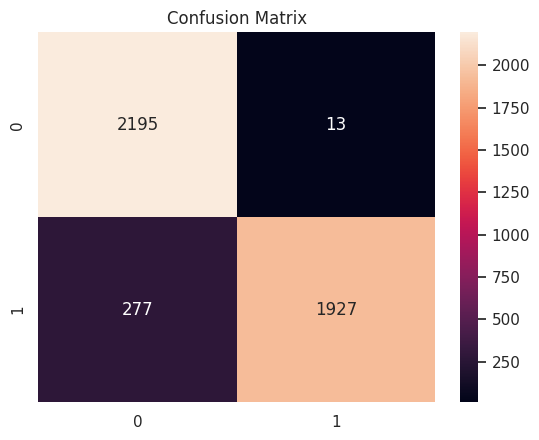

In [87]:
# Pola 
# | TP  | FP |
# | FN  | TN |
con_mat = confusion_matrix(y_test, y_pred_grid_val)
sns.heatmap(con_mat, annot=True, fmt=".5g").set(title="Confusion Matrix");

In [88]:
# Kita bandingkan hasil prediksi model dengan nilai aktual
pd.DataFrame({
    "y_aktual": y_test,
    "y_pred": y_pred_grid_val
}).head(20)

,y_aktual,y_pred
4295,0,0
7632,0,0
2646,0,0
978,0,0
10137,0,0
20278,1,1
9095,0,0
20124,1,1
10804,0,0
11826,1,0


In [89]:
# Menggunakan Deep Learning
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

model_deep = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu", input_shape=(X_test_scaled.shape[1],)),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam()
model_deep.compile(optimizer=optimizer,
              loss="binary_crossentropy", metrics=["acc"]              
)

history = model_deep.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), callbacks=[es], epochs=100)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752549649.976588      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/100


I0000 00:00:1752549652.970514     101 service.cc:148] XLA service 0x7b979c00ca40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752549652.970970     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752549653.247676     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 71/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8169 - loss: 3.9187

I0000 00:00:1752549653.954453     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


552/552 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.8913 - loss: 1.4151 - val_acc: 0.9320 - val_loss: 0.2390
Epoch 2/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9302 - loss: 0.2294 - val_acc: 0.9340 - val_loss: 0.2169
Epoch 3/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9337 - loss: 0.2129 - val_acc: 0.9325 - val_loss: 0.2094
Epoch 4/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9299 - loss: 0.2120 - val_acc: 0.9347 - val_loss: 0.2091
Epoch 5/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9313 - loss: 0.2076 - val_acc: 0.9336 - val_loss: 0.2051
Epoch 6/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9321 - loss: 0.2037 - val_acc: 0.9354 - val_loss: 0.2058
Epoch 7/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.9299 - loss: 0.2078 - val_acc: 0.9347 - val_loss: 0.2039
Epoch 8/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.9315 - loss: 0.2027 - val_acc: 0.9343 - val_loss: 0.2010
Epoch 9/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 

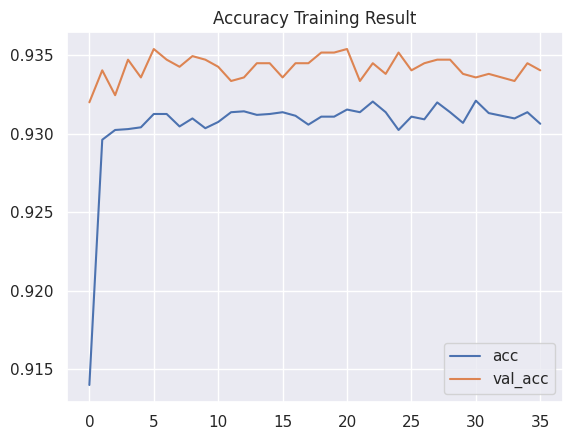

In [90]:
fig, ax = plt.subplots()
plt.plot(history.history["acc"], label="acc")
plt.plot(history.history["val_acc"], label="val_acc")
ax.set_title("Accuracy Training Result")
plt.legend();

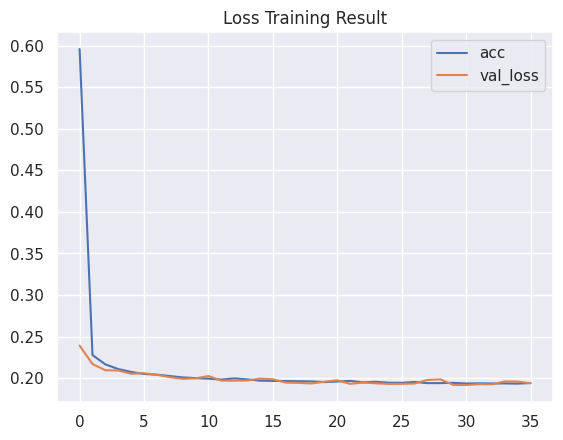

In [91]:
fig, ax = plt.subplots()
plt.plot(history.history["loss"], label="acc")
plt.plot(history.history["val_loss"], label="val_loss")
ax.set_title("Loss Training Result")
plt.legend();

In [92]:
# Kita tampilkan  model evaluasi akurasi dan loss dari hasil training
loss, acc_deep = model_deep.evaluate(X_test_scaled, y_test)
print(f"Loss = {loss}")
print(f"Accuracy = {acc_deep}")

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9320 - loss: 0.1930
Loss = 0.19365301728248596
Accuracy = 0.9340435266494751


In [93]:
# Kita bandingkan accuracy antara model random forest grid dengan model deep learning
pd.DataFrame({
    "Random Forest Grid": [grid_acc],
    "Deep Learning": [acc_deep]
}, index=["accuracy"])

,Random Forest Grid,Deep Learning
accuracy,0.93427,0.934044


In [94]:
y_pred_deep = model_deep.predict(X_test_scaled)

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


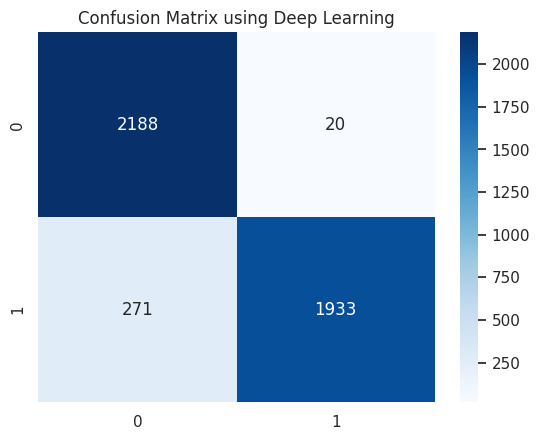

In [95]:

# Ubah bentuk array 2D kedalam array 1D (vektor)
y_pred_deep = y_pred_deep.round().flatten()
con_max_deep = confusion_matrix(y_test, y_pred_deep)
sns.heatmap(con_max_deep, annot=True, cmap="Blues", fmt=".5g").set(title="Confusion Matrix using Deep Learning");

In [96]:
pd.DataFrame({
    "y_aktual": y_test,
    "y_model_grid_random_forest": y_pred_grid_val,
    "y_pred_deep": y_pred_deep.astype("int32")
}).head(20)

,y_aktual,y_model_grid_random_forest,y_pred_deep
4295,0,0,0
7632,0,0,0
2646,0,0,0
978,0,0,0
10137,0,0,0
20278,1,1,1
9095,0,0,0
20124,1,1,1
10804,0,0,0
11826,1,0,0


In [97]:
# Kita bandingkan akurasi semua model yang sebelumnya sudah ada dengan model deep learning.
pd.DataFrame({
    "RandomForestClassifier": rf_acc,
    "LogisticRegression": lr_acc,
    "SVC": svc_acc,
    "GaussianNB": nb_acc,
    "KNeighborClassifier": kn_acc,
    "DecisionTreeClassifier": dt_acc,
    "Grid RandomForestClassifier": grid_acc,
    "DeepLearning": acc_deep
}, index=["accuracy"]).T.sort_values(by="accuracy", ascending=False)

,accuracy
LogisticRegression,0.934664
SVC,0.934664
Grid RandomForestClassifier,0.934270
DeepLearning,0.934044
GaussianNB,0.933759
RandomForestClassifier,0.931144
KNeighborClassifier,0.921989
DecisionTreeClassifier,0.893069
